In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import plot_utils, summary_plots, load_fits
from utils import roi_utils, default_paths, prf_utils
from feature_extraction import gabor_feature_extractor


#### Load fit results

In [15]:
# subjects = np.arange(1,9)
subjects=[1]
n_subjects = len(subjects)

noise_level = 0.10

trial_subsets = ['all',\
                 'balance_indoor_outdoor','outdoor_only','indoor_only',\
                 'balance_animacy', 'animate_only', 'inanimate_only',\
                 'balance_real_world_size_binary','large_only', 'small_only']

n_trial_subsets = len(trial_subsets)

fitting_types = ['gabor_solo_ridge_12ori_8sf_%s_simulated_gabor_addnoise_0.10'%ts for ts in trial_subsets]
fitting_types[0] = 'gabor_solo_ridge_12ori_8sf_simulated_gabor_addnoise_0.10'

out = [[load_fits.load_fit_results(subject=ss, fitting_type=ft, n_from_end=0, \
                                  verbose=False) for ss in subjects] for ft in fitting_types]


In [18]:
[[np.all(out[fi][si]['best_lambdas']==0) for si in range(n_subjects)] for fi in range(n_trial_subsets)]

[[False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False]]

#### load the ground-truth feature prefs of the simulated voxels

In [67]:
thing = '/user_data/mmhender/features/gabor_texture/simulated_data/S1_sim_data_addnoise_0.10.npy'
sim = np.load(thing, allow_pickle=True).item()
sim_prf_inds = sim['simulated_voxel_prf_inds']
assert(np.all(out[0][0]['best_params'][5][:,0]==sim_prf_inds))
sim_orient = sim['simulated_voxel_orient']
sim_sf = sim['simulated_voxel_sf']
un, sim_sf_inds = np.unique(sim_sf, return_inverse=True)

In [64]:
un, sim_sf_inds = np.unique(sim_sf, return_inverse=True)

In [66]:
sim_sf

array([0.35714286, 0.35714286, 0.35714286, ..., 8.57142857, 8.57142857,
       8.57142857])

In [65]:
sim_sf_inds

array([0, 0, 0, ..., 7, 7, 7])

In [6]:
prf_pars = out[0][0]['models'][sim_prf_inds,:].round(2)

#### Get info about the Gabor feature space

In [7]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


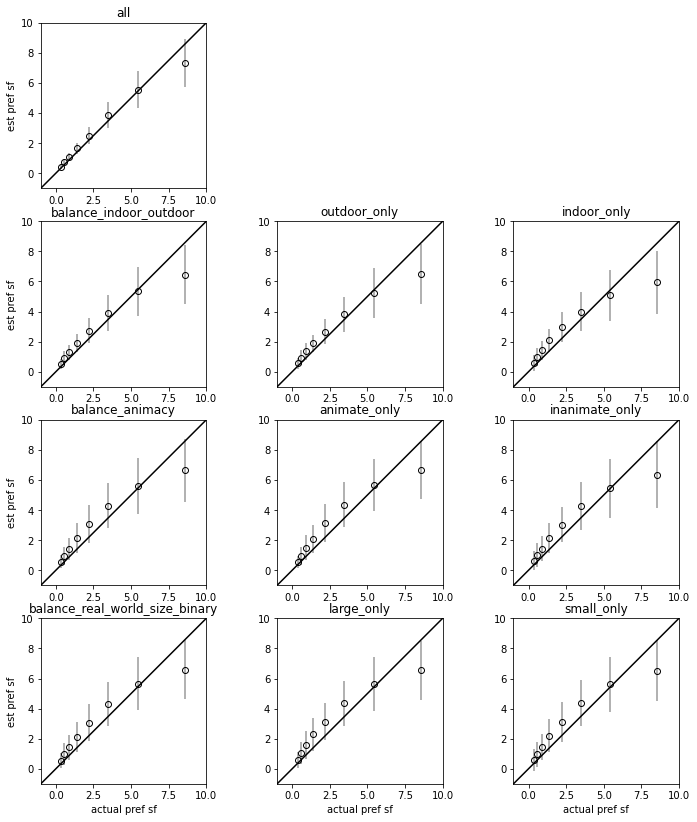

In [60]:
from utils import numpy_utils

plt.figure(figsize=(12,14))
pi=0;
    
for fi, trial_subset in enumerate(trial_subsets):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
    
    est_sf = np.array(sf_unique)[preferred_sf_corr.astype(int)]
    
    
    x,y = sim_sf, est_sf
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x,y, n_bins=len(np.unique(x)),\
                                                            use_unique=True, linear_bins=False,\
                                                            return_std=True)
    pi+=1
    plt.subplot(4,3,pi)
    plt.plot(xbinned, ybinned, 'o',markerfacecolor='none',color='k')
    plt.errorbar(xbinned,ybinned, ystd, linestyle='none',color=[0.6, 0.6, 0.6])
    # plt.plot( x,y, '.',alpha=0.2)
    # plt.xticks(np.arange(0,180,45))
    # plt.yticks(np.arange(0,180,45))
    plt.axis('square')
    lims = [-1, 10]
    # lims = [-5, 180]
    plt.plot(lims, lims, color='k')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.title('prf size=%.2f'%(size*8.4))
    if pi>9:
        plt.xlabel('actual pref sf')
    if np.mod(pi,3)==1:
        plt.ylabel('est pref sf')

    plt.title('%s'%trial_subset)
    
    if fi==0:
        pi+=2

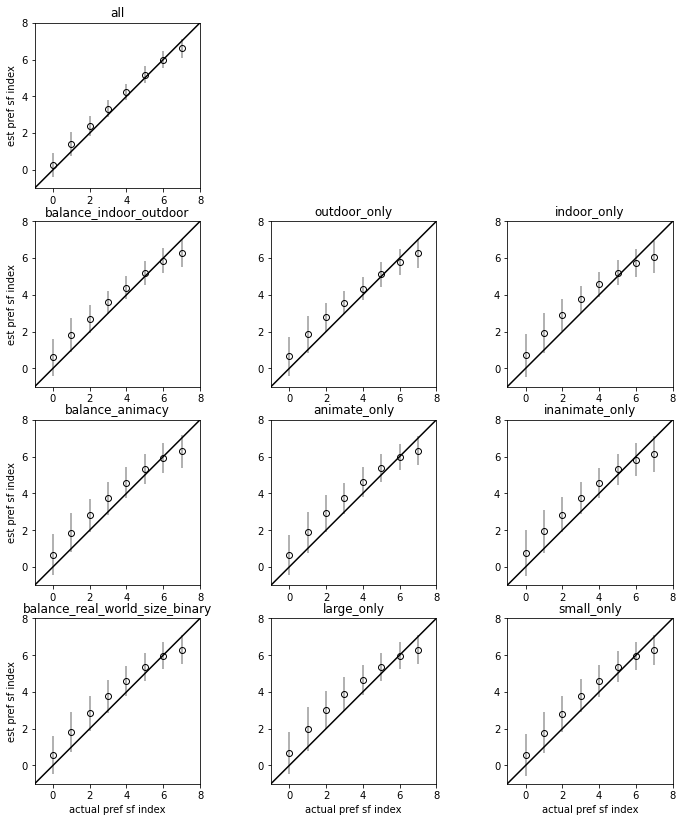

In [69]:
from utils import numpy_utils

plt.figure(figsize=(12,14))
pi=0;
    
for fi, trial_subset in enumerate(trial_subsets):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
    
    est_sf = preferred_sf_corr.astype(int)
    
    
    x,y = sim_sf_inds, est_sf
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x,y, n_bins=len(np.unique(x)),\
                                                            use_unique=True, linear_bins=False,\
                                                            return_std=True)
    pi+=1
    plt.subplot(4,3,pi)
    plt.plot(xbinned, ybinned, 'o',markerfacecolor='none',color='k')
    plt.errorbar(xbinned,ybinned, ystd, linestyle='none',color=[0.6, 0.6, 0.6])
    # plt.plot( x,y, '.',alpha=0.2)
    # plt.xticks(np.arange(0,180,45))
    # plt.yticks(np.arange(0,180,45))
    plt.axis('square')
    lims = [-1, 8]
    # lims = [-5, 180]
    plt.plot(lims, lims, color='k')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.title('prf size=%.2f'%(size*8.4))
    if pi>9:
        plt.xlabel('actual pref sf index')
    if np.mod(pi,3)==1:
        plt.ylabel('est pref sf index')

    plt.title('%s'%trial_subset)
    
    if fi==0:
        pi+=2

In [13]:
np.unique(x)

array([0.35714286, 0.56236075, 0.88549892, 1.39431555, 2.19550336,
       3.45706178, 5.44352442, 8.57142857])

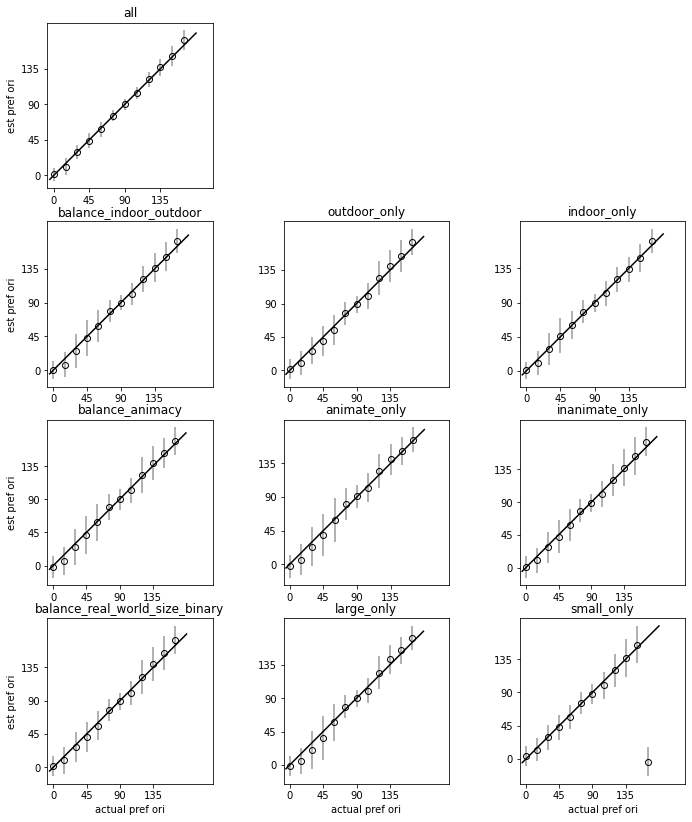

In [61]:
from utils import numpy_utils

import scipy.stats

plt.figure(figsize=(12,14))
pi=0;

for fi, trial_subset in enumerate(trial_subsets):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

   
    est_orient = np.array(ori_unique)[preferred_ori_corr.astype(int)]
    
    x,y = sim_orient, est_orient
    xbinned = np.unique(x)
    ybinned = np.array([scipy.stats.circmean(y[x==xb], high=180,low=0) for xb in xbinned])
    ystd = np.array([scipy.stats.circstd(y[x==xb], high=180,low=0) for xb in xbinned])

    ybinned[ybinned>175] = ybinned[ybinned>175]-180
    # xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x,y, n_bins=len(np.unique(x)),\
    #                                                         use_unique=True, return_std=True)
    pi+=1
    plt.subplot(4,3,pi)
    plt.plot(xbinned, ybinned, 'o',color='k',markerfacecolor='none')
    plt.errorbar(xbinned,ybinned, ystd,linestyle='none',color=[0.6, 0.6, 0.6])
    # plt.errorbar(xbinned,ybinned)
    # plt.plot( x,y, '.',alpha=0.2)
    plt.xticks(np.arange(0,180,45))
    plt.yticks(np.arange(0,180,45))
    plt.axis('square')
    lims = [-5, 180]
    plt.plot(lims, lims, color='k')
    plt.title('prf size=%.2f'%(size*8.4))
    if pi>9:
        plt.xlabel('actual pref ori')
    if np.mod(pi,3)==1:
        plt.ylabel('est pref ori')

    plt.title('%s'%trial_subset)
    
    if fi==0:
        pi+=2

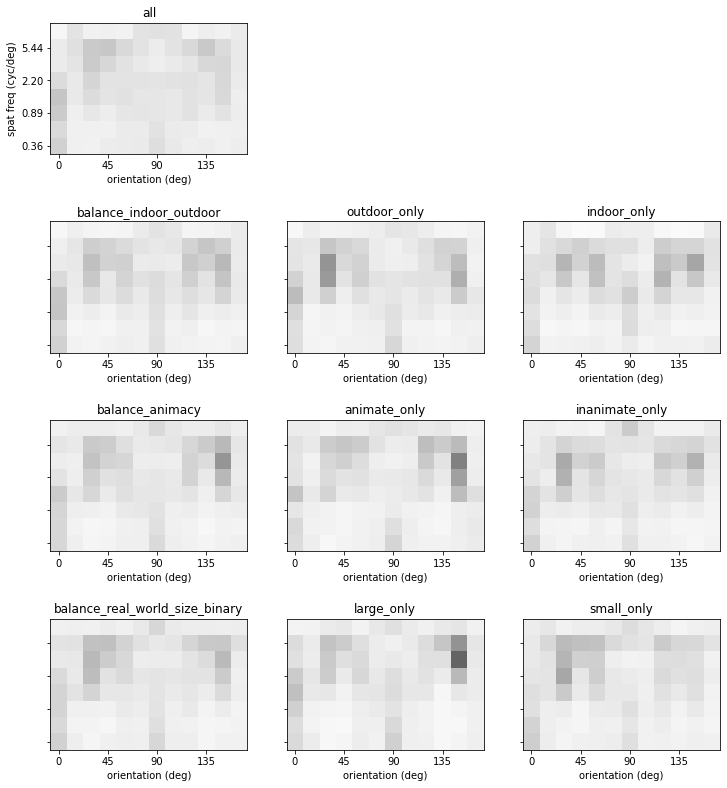

In [75]:
plt.figure(figsize=(12,14))

pi=0;

for fi, trial_subset in enumerate(trial_subsets):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    is_constant = np.all(mean_orient_corr[:,0:1]==mean_orient_corr, axis=1)
    assert not np.any(is_constant)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

    n_vox = preferred_ori_corr.shape[0]
    feature_prefs_2dhist = np.zeros((n_vox, n_ori, n_sf))
    for vv in range(n_vox):
        oo = int(preferred_ori_corr[vv])
        ff = int(preferred_sf_corr[vv])
        feature_prefs_2dhist[vv,oo,ff] = 1

    pi+=1
    plt.subplot(4,3,pi)
    vals = np.mean(feature_prefs_2dhist, axis=0).T
    plt.pcolormesh(vals, cmap='gray_r', vmin=0, vmax=0.10)
    # plt.colorbar()
    plt.xlabel('orientation (deg)')
    plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
    sf_ticks = sf_unique[[0,2,4,6]].round(2)
    if fi==0:
        plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
        plt.ylabel('spat freq (cyc/deg)')
    else:
        plt.yticks(np.array([0,2,4,6])+0.5, [])
    plt.title('%s'%trial_subset)
    plt.axis('square')
    plt.xlim([0,12])
    plt.ylim([0,8])
    
    if fi==0:
        pi+=2
    # plt.suptitle('pRF size=%.2f'%(size))


In [76]:
1/96

0.010416666666666666

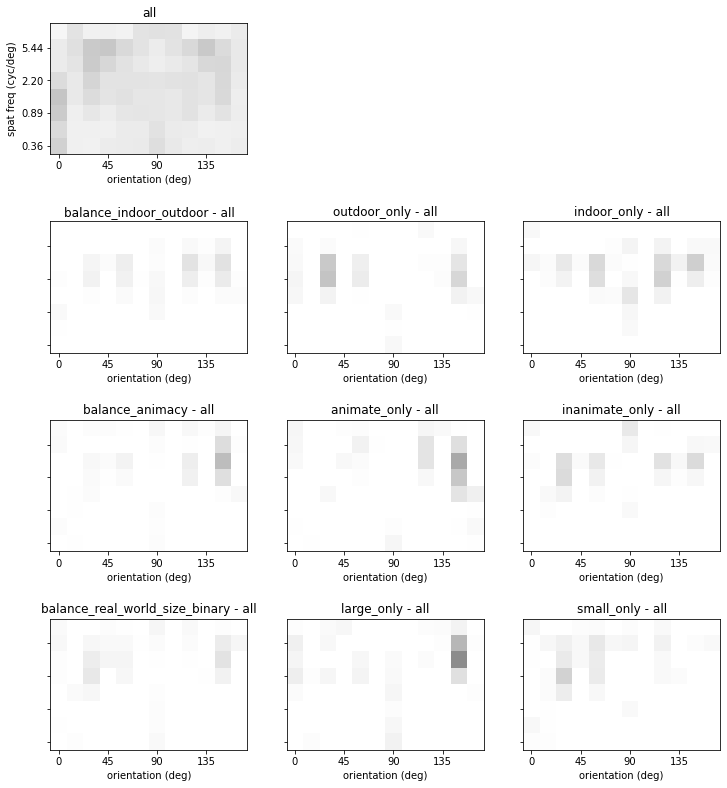

In [74]:
plt.figure(figsize=(12,14))

pi=0;

for fi, trial_subset in enumerate(trial_subsets):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    is_constant = np.all(mean_orient_corr[:,0:1]==mean_orient_corr, axis=1)
    assert not np.any(is_constant)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

    n_vox = preferred_ori_corr.shape[0]
    feature_prefs_2dhist = np.zeros((n_vox, n_ori, n_sf))
    for vv in range(n_vox):
        oo = int(preferred_ori_corr[vv])
        ff = int(preferred_sf_corr[vv])
        feature_prefs_2dhist[vv,oo,ff] = 1

    pi+=1
    plt.subplot(4,3,pi)
    vals = np.mean(feature_prefs_2dhist, axis=0).T
    if fi==0:
        vals_all = vals
    else:
        vals = vals - vals_all
    plt.pcolormesh(vals, cmap='gray_r', vmin=0, vmax=0.10)
    # plt.colorbar()
    plt.xlabel('orientation (deg)')
    plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
    sf_ticks = sf_unique[[0,2,4,6]].round(2)
    if fi==0:
        plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
        plt.ylabel('spat freq (cyc/deg)')
    else:
        plt.yticks(np.array([0,2,4,6])+0.5, [])
    if fi==0:
        plt.title('%s'%trial_subset)
    else:
        plt.title('%s - all'%trial_subset)
    plt.axis('square')
    plt.xlim([0,12])
    plt.ylim([0,8])
    
    if fi==0:
        pi+=2
    # plt.suptitle('pRF size=%.2f'%(size))


In [73]:
np.sum(vals_all)

1.0

In [33]:
fi = 4;
feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)


est_orient = np.array(ori_unique)[preferred_ori_corr.astype(int)]

x,y = sim_orient, est_orient
xbinned = np.unique(x)
ybinned = [scipy.stats.circmean(y[x==xb], high=180,low=0) for xb in xbinned]
ystd = [scipy.stats.circstd(y[x==xb], high=180,low=0) for xb in xbinned]


In [37]:
ybinned[0]-180

-1.618712323847177

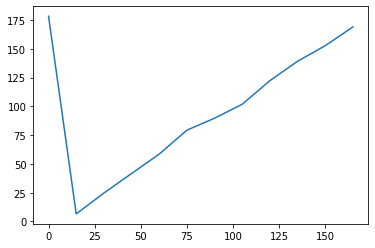

In [34]:
plt.figure()
plt.plot(xbinned, ybinned)

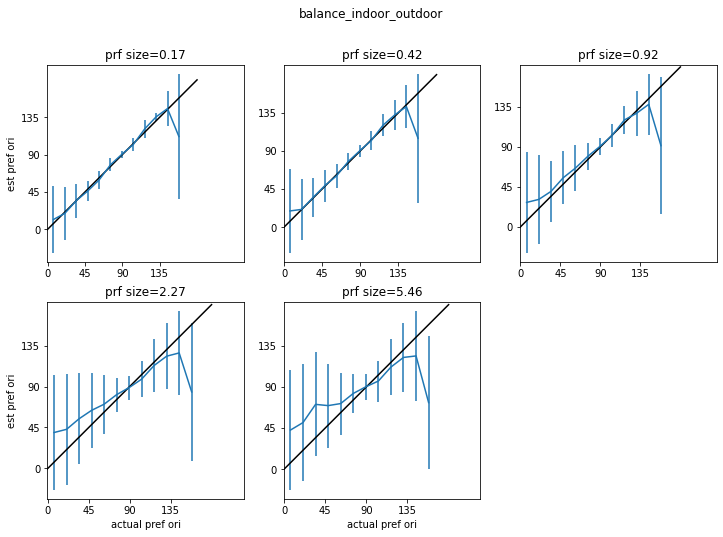

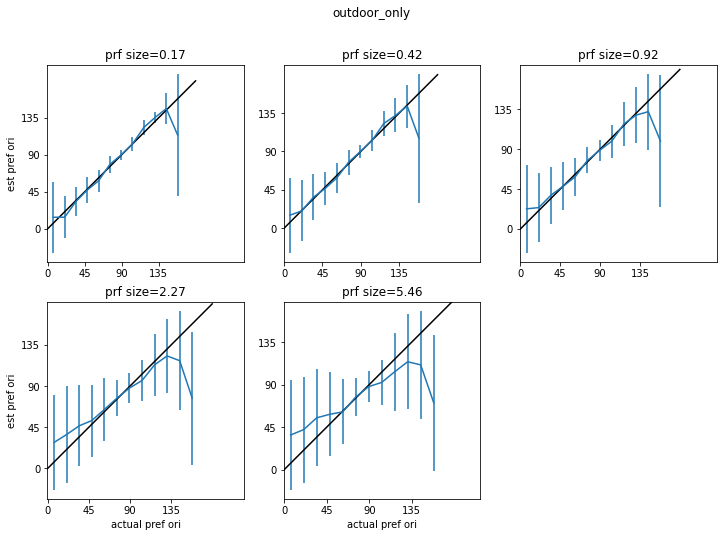

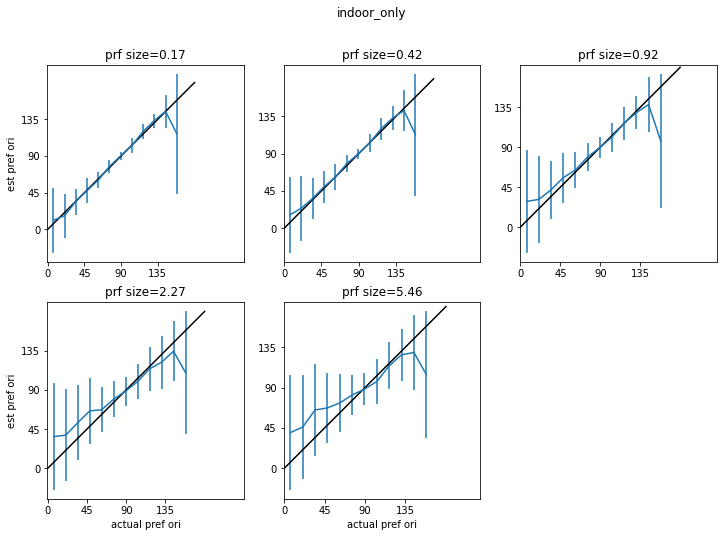

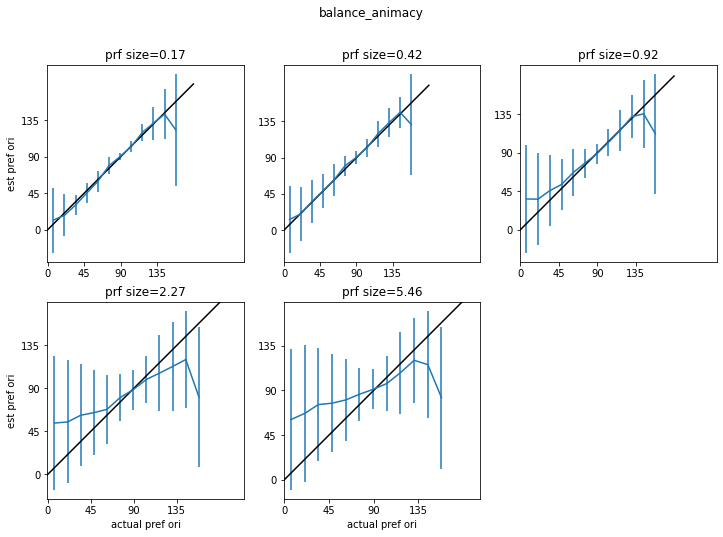

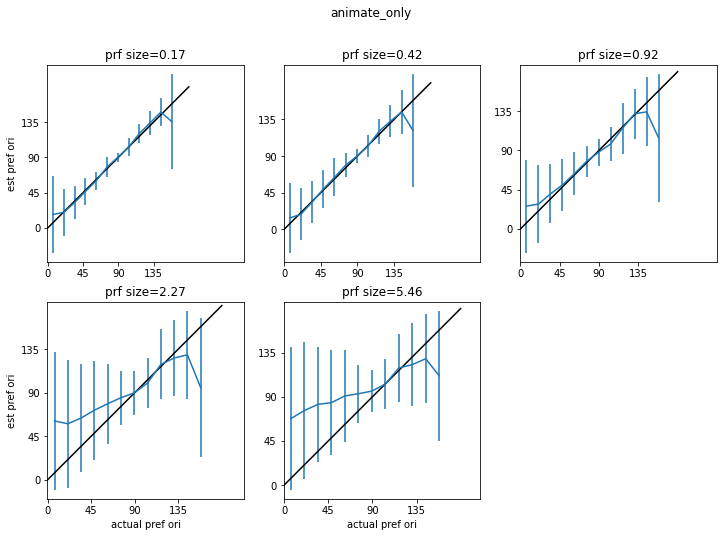

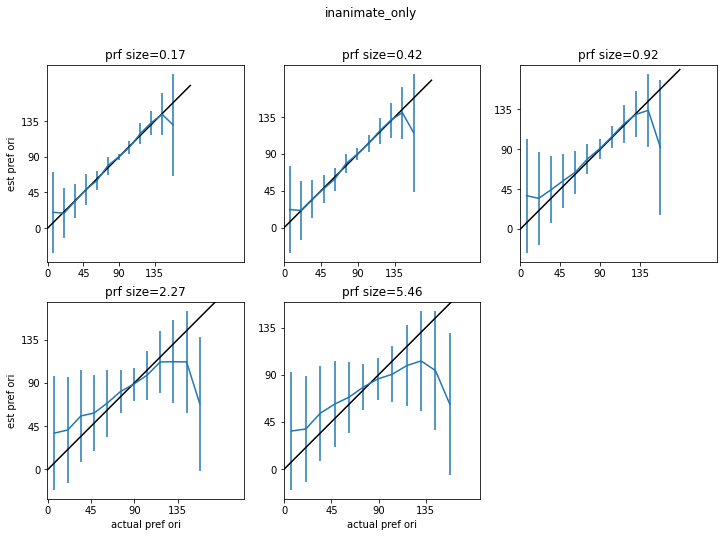

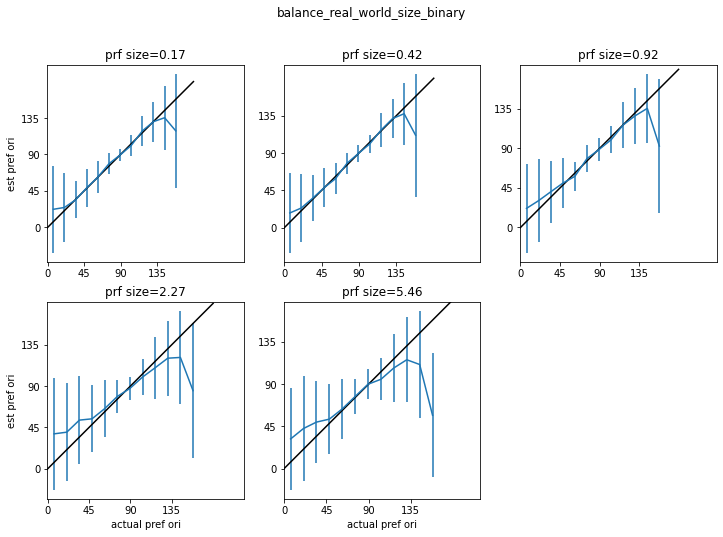

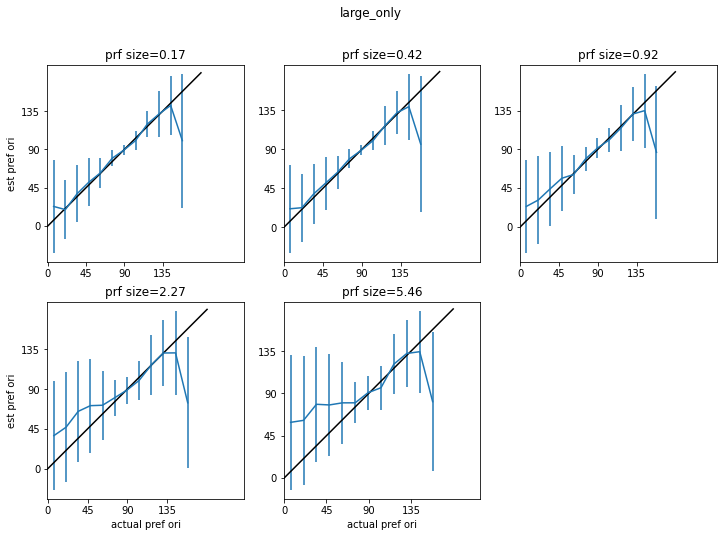

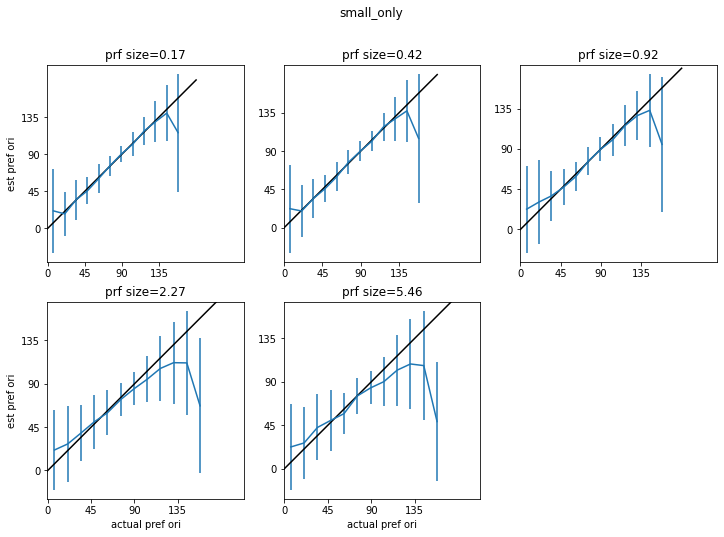

In [8]:
from utils import numpy_utils

for fi, trial_subset in enumerate(trial_subsets):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

    plt.figure(figsize=(12,8))
    pi=0;
    est_orient = np.array(ori_unique)[preferred_ori_corr.astype(int)]
    for size in np.unique(prf_pars[:,2]):

        vox_inds = prf_pars[:,2]==size

        x,y = sim_orient[vox_inds], est_orient[vox_inds]
        xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x,y, n_bins=len(np.unique(x)),\
                                                                use_unique=True, return_std=True)
        pi+=1
        plt.subplot(2,3,pi)
        plt.errorbar(xbinned,ybinned, ystd)
        # plt.plot( x,y, '.',alpha=0.2)
        plt.xticks(np.arange(0,180,45))
        plt.yticks(np.arange(0,180,45))
        plt.axis('square')
        lims = [-5, 180]
        plt.plot(lims, lims, color='k')
        plt.title('prf size=%.2f'%(size*8.4))
        if pi>3:
            plt.xlabel('actual pref ori')
        if np.mod(pi,3)==1:
            plt.ylabel('est pref ori')

    plt.suptitle('%s'%trial_subset)

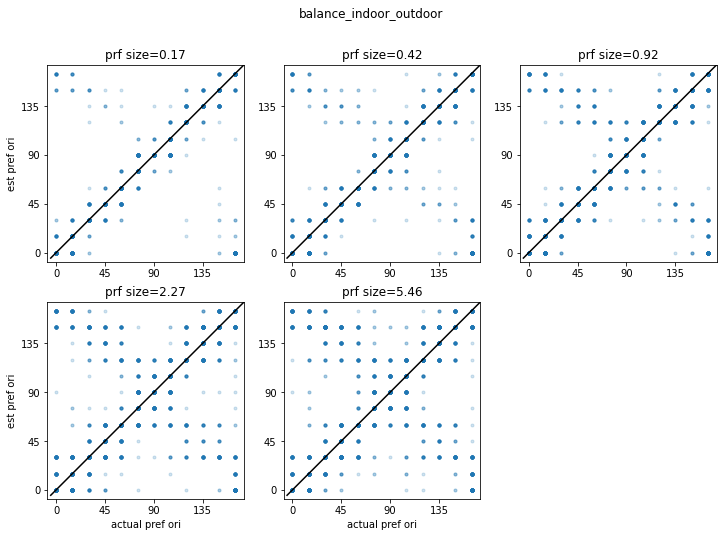

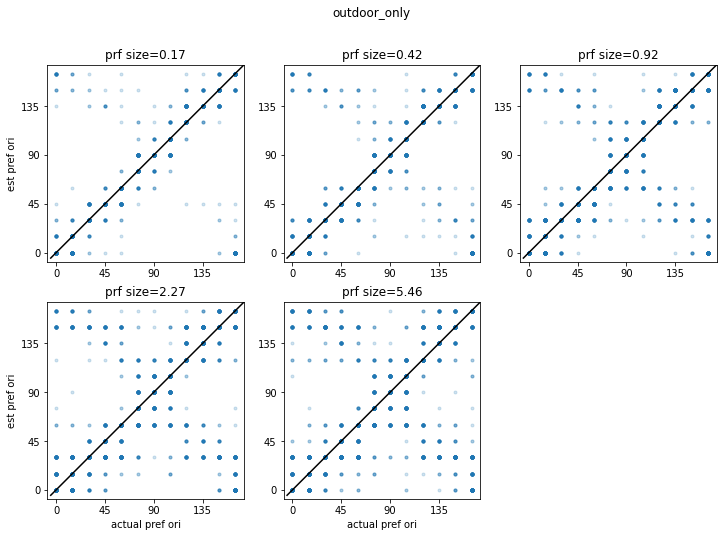

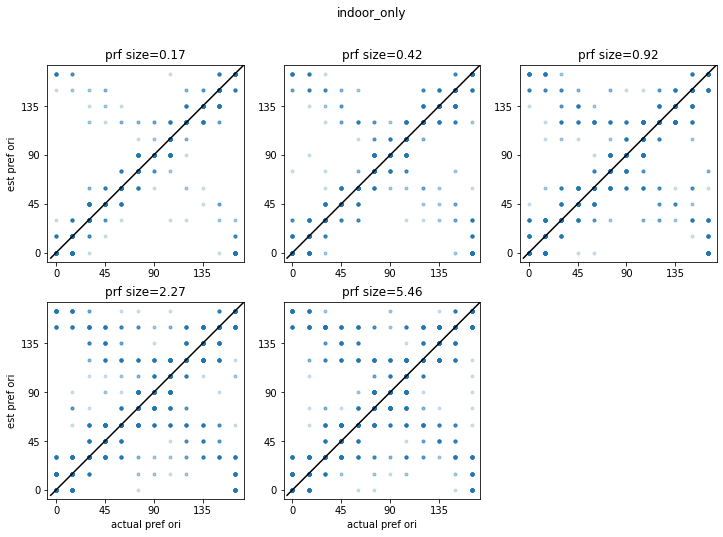

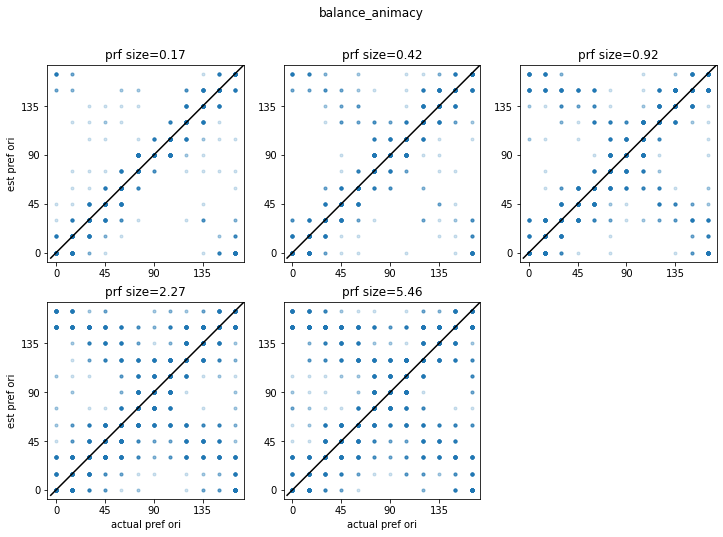

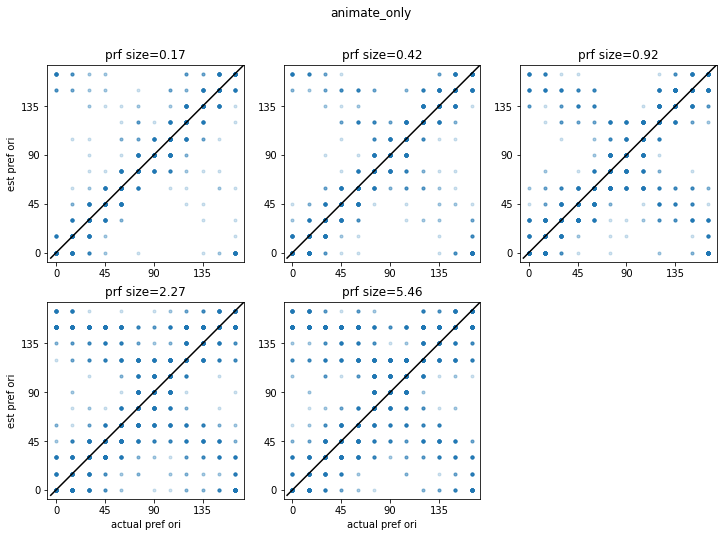

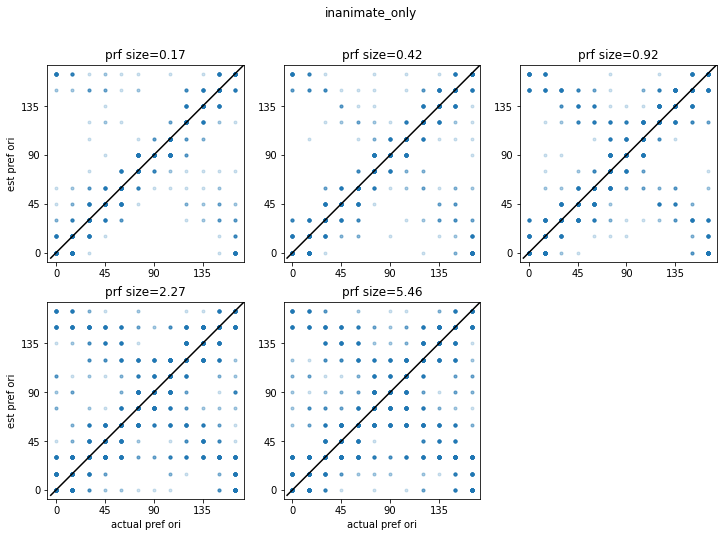

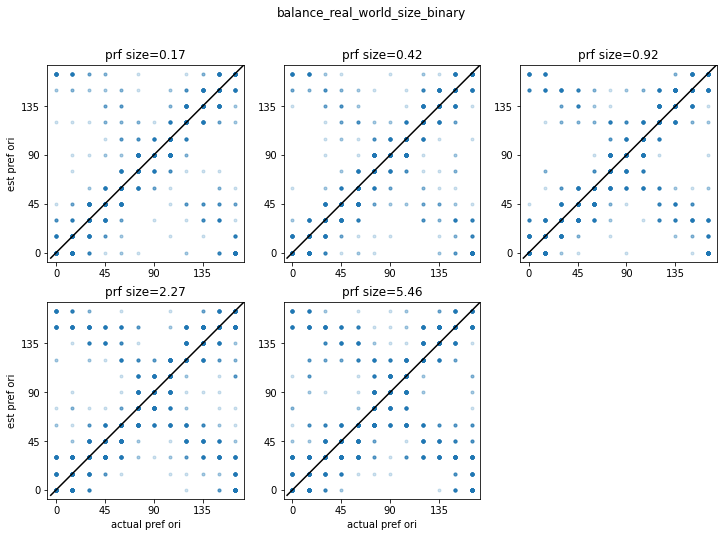

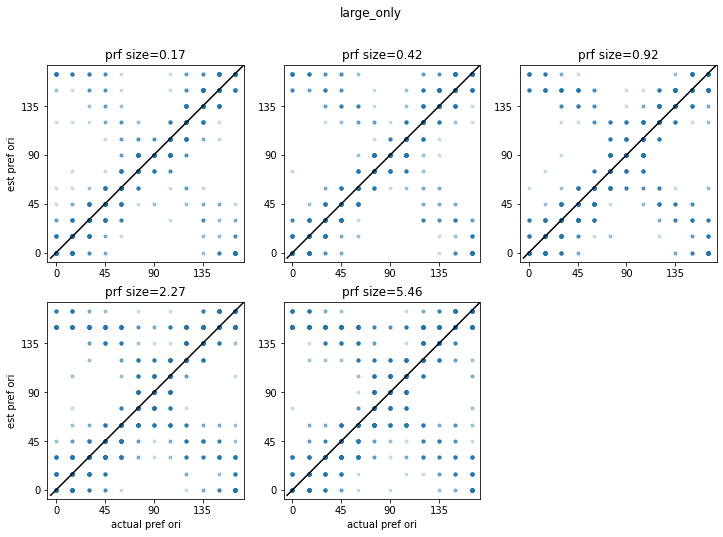

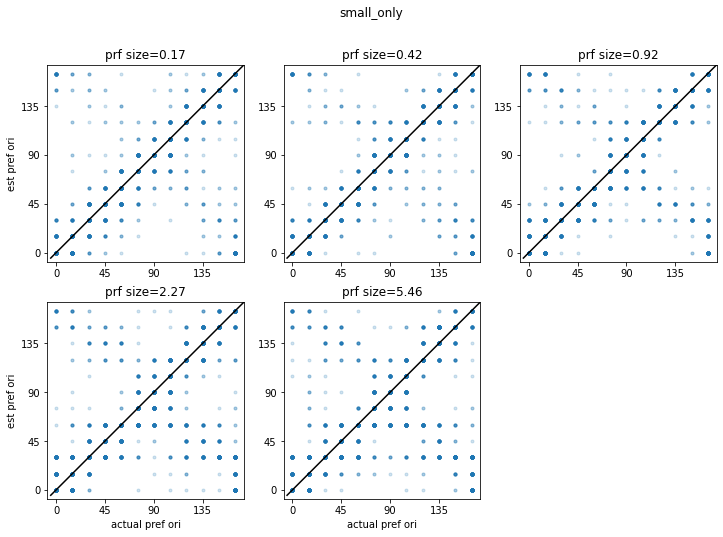

In [222]:
for fi, trial_subset in enumerate(trial_subsets):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

    plt.figure(figsize=(12,8))
    pi=0;
    est_orient = np.array(ori_unique)[preferred_ori_corr.astype(int)]
    for size in np.unique(prf_pars[:,2]):

        vox_inds = prf_pars[:,2]==size

        pi+=1
        plt.subplot(2,3,pi)
        plt.plot( sim_orient[vox_inds], est_orient[vox_inds], '.',alpha=0.2)
        plt.xticks(np.arange(0,180,45))
        plt.yticks(np.arange(0,180,45))
        plt.axis('square')
        lims = [-5, 180]
        plt.plot(lims, lims, color='k')
        plt.title('prf size=%.2f'%(size*8.4))
        if pi>3:
            plt.xlabel('actual pref ori')
        if np.mod(pi,3)==1:
            plt.ylabel('est pref ori')

    plt.suptitle('%s'%trial_subset)

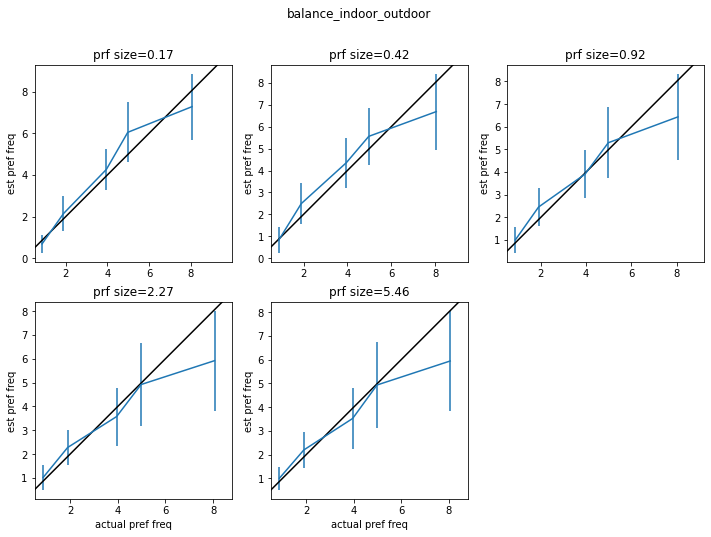

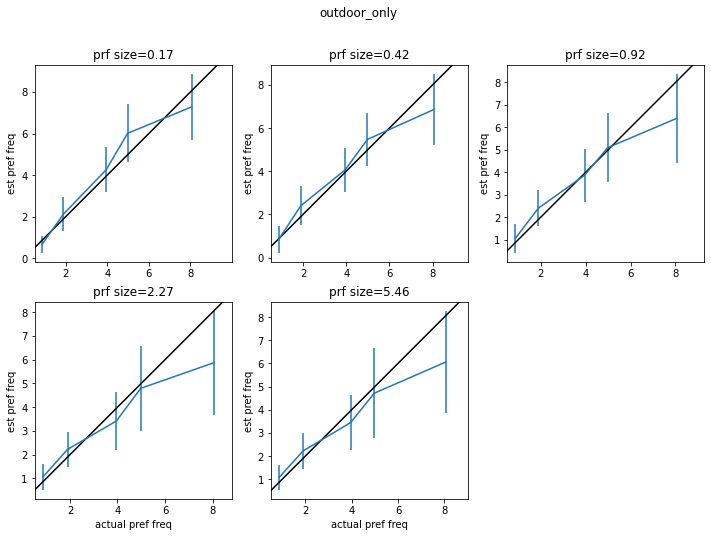

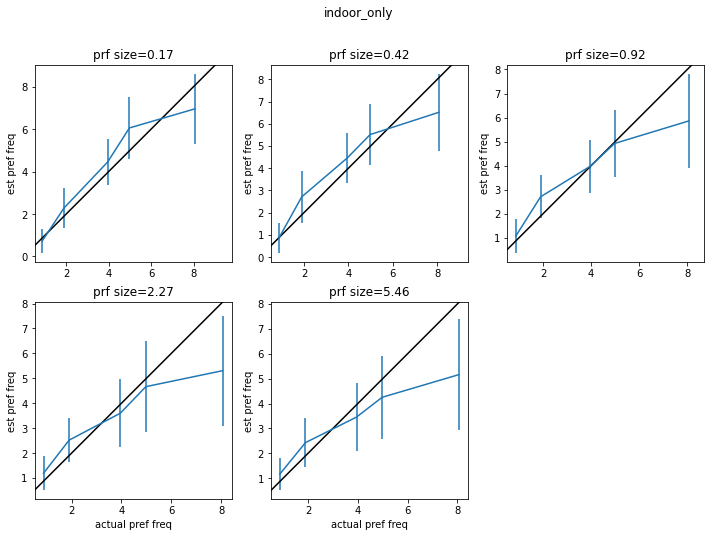

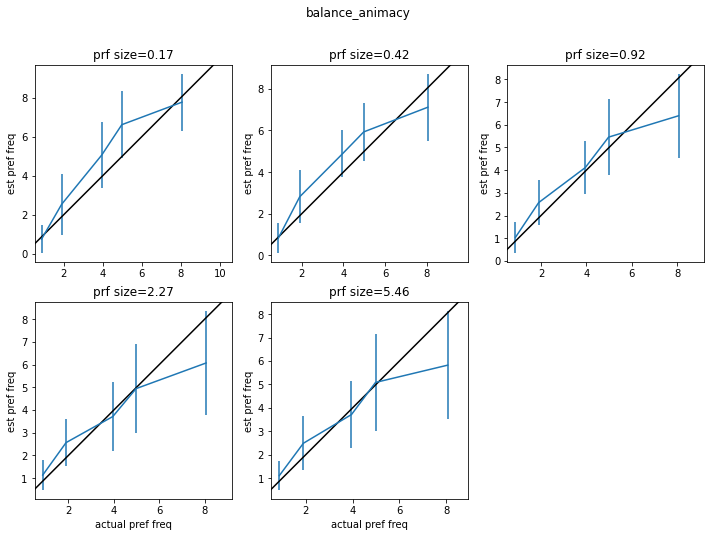

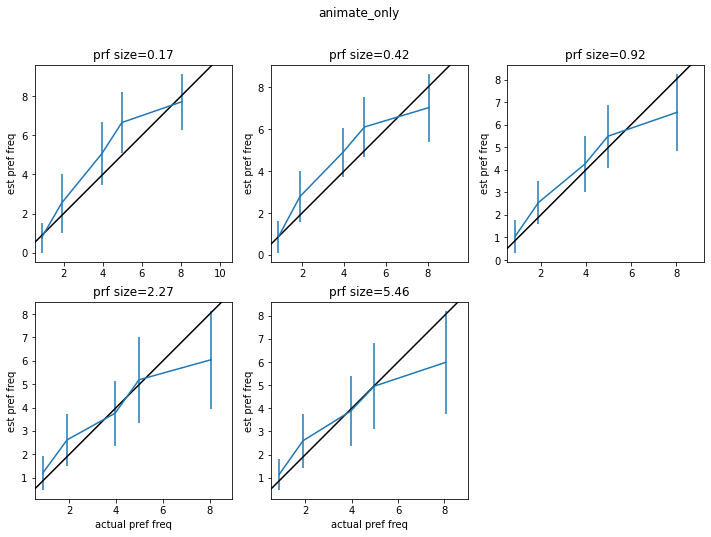

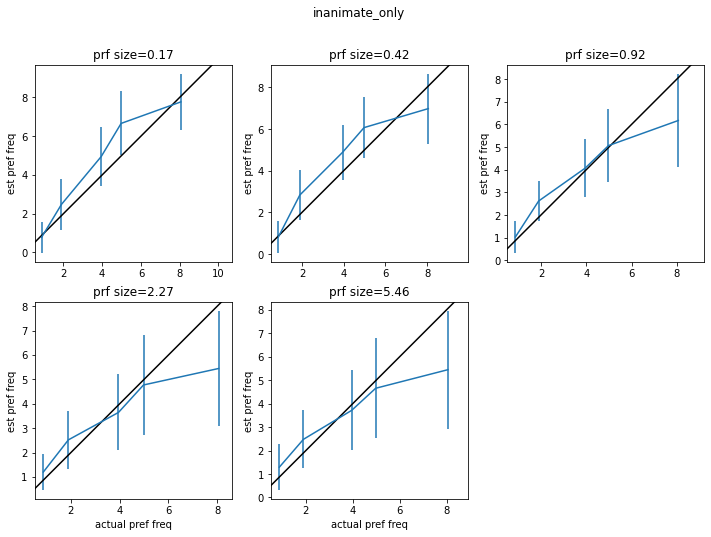

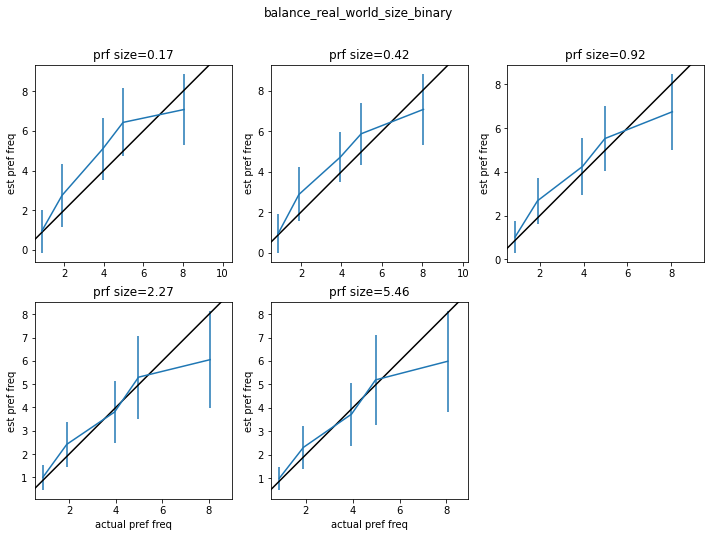

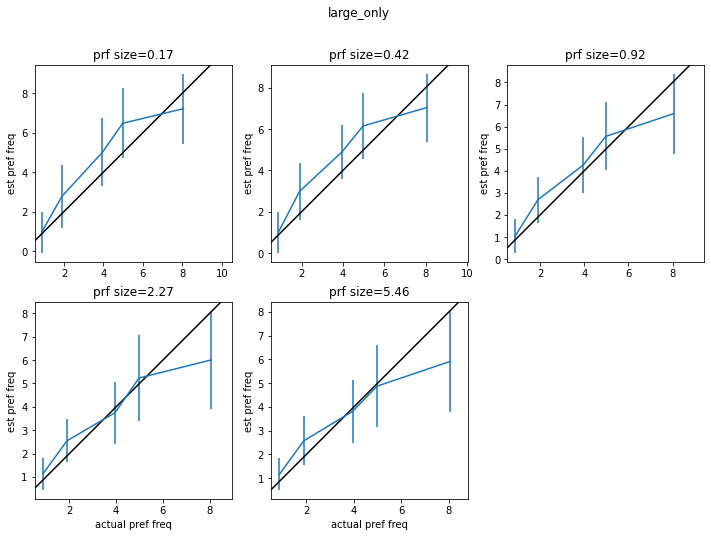

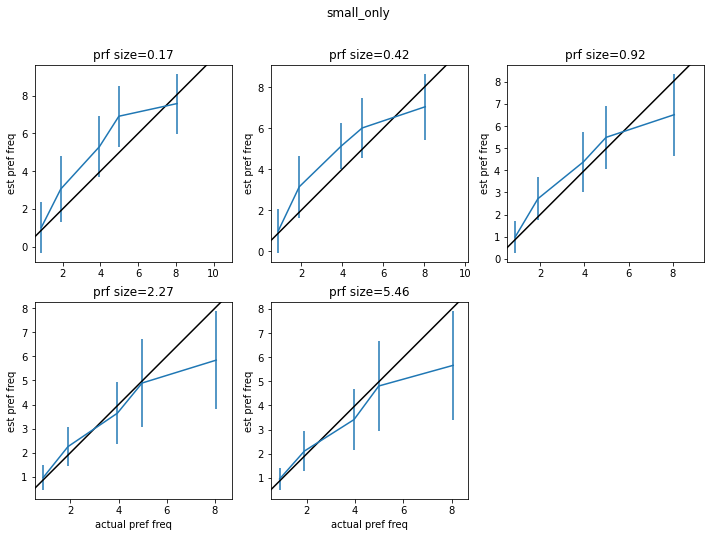

In [258]:
for fi, trial_subset in enumerate(trial_subsets):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

    plt.figure(figsize=(12,8))
    pi=0;
    est_sf = np.array(sf_unique)[preferred_sf_corr.astype(int)]
    for size in np.unique(prf_pars[:,2]):

        vox_inds = prf_pars[:,2]==size

        x,y = sim_sf[vox_inds], est_sf[vox_inds]
        xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x,y, n_bins=len(np.unique(x)),\
                                                                use_unique=True, return_std=True)
        pi+=1
        plt.subplot(2,3,pi)
        plt.errorbar(xbinned,ybinned,ystd)
        # plt.plot( sim_sf[vox_inds], est_sf[vox_inds], '.',alpha=1.0)
        # plt.xticks(sf_unique);
        # plt.yticks(sf_unique);
        plt.axis('square')
        lims = [-1,10]
        plt.plot(lims, lims, color='k')
        plt.title('prf size=%.2f'%(size*8.4))
        if pi>3:
            plt.xlabel('actual pref freq')
        plt.ylabel('est pref freq')
    
    plt.suptitle('%s'%trial_subset)

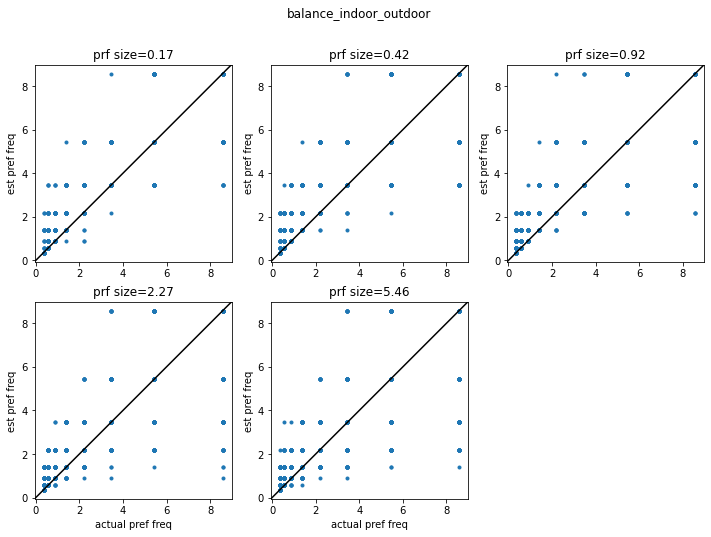

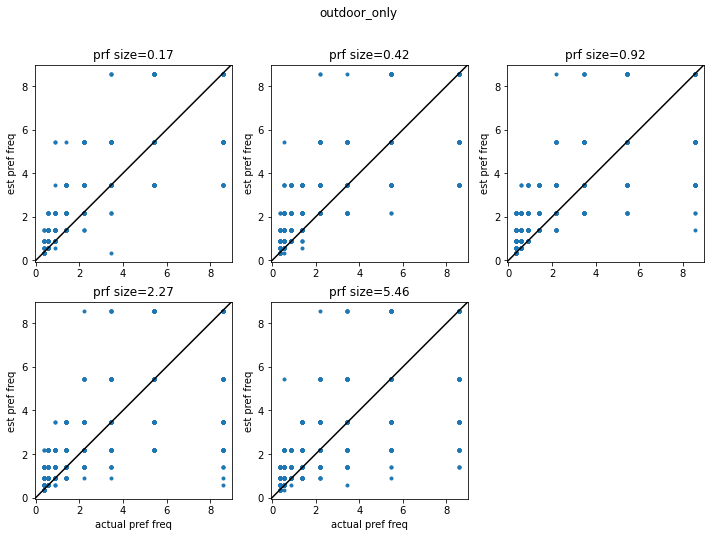

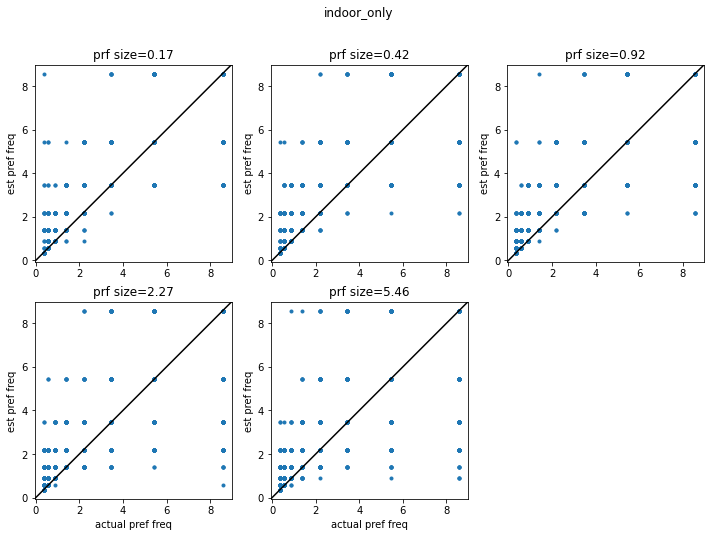

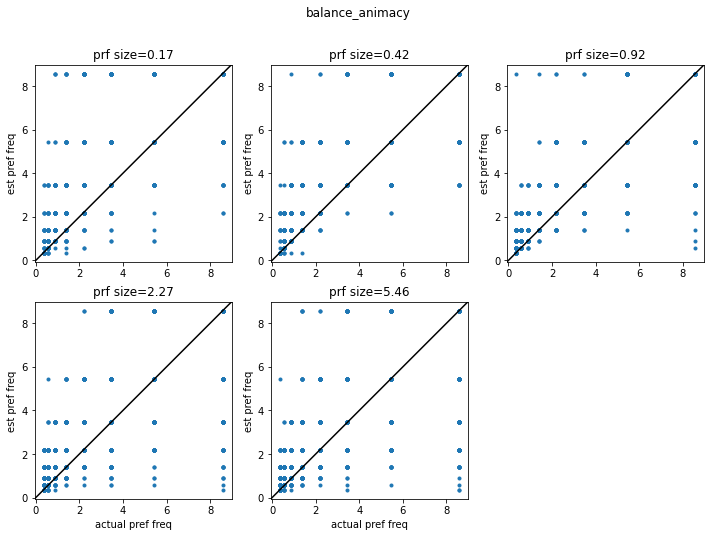

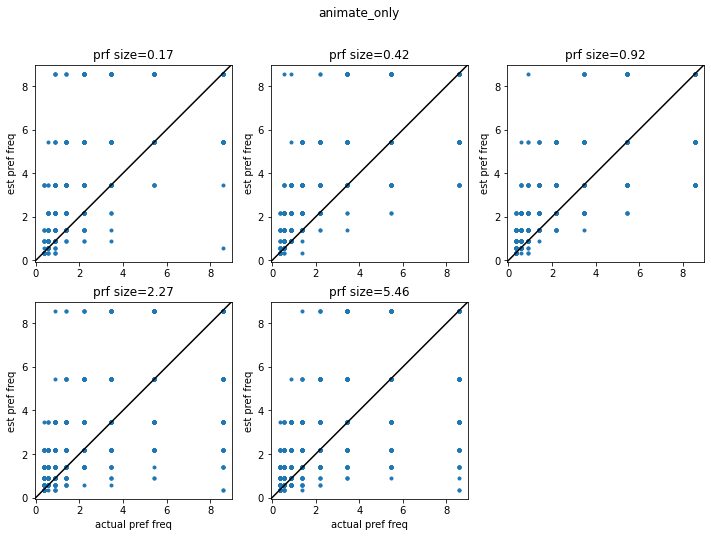

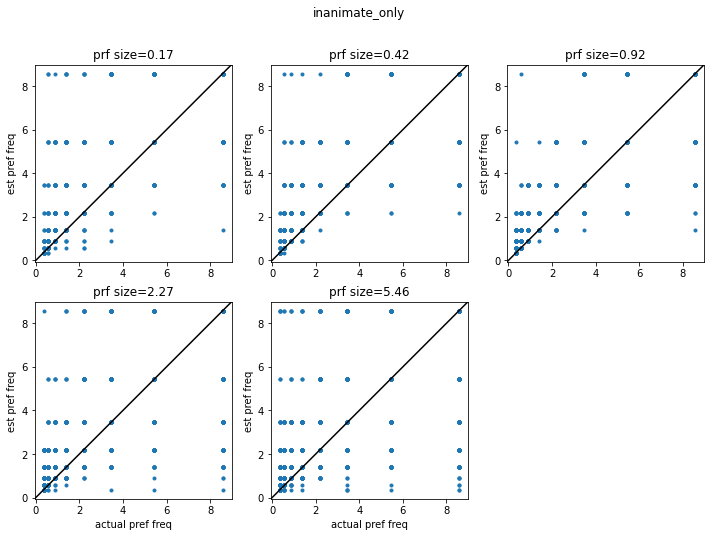

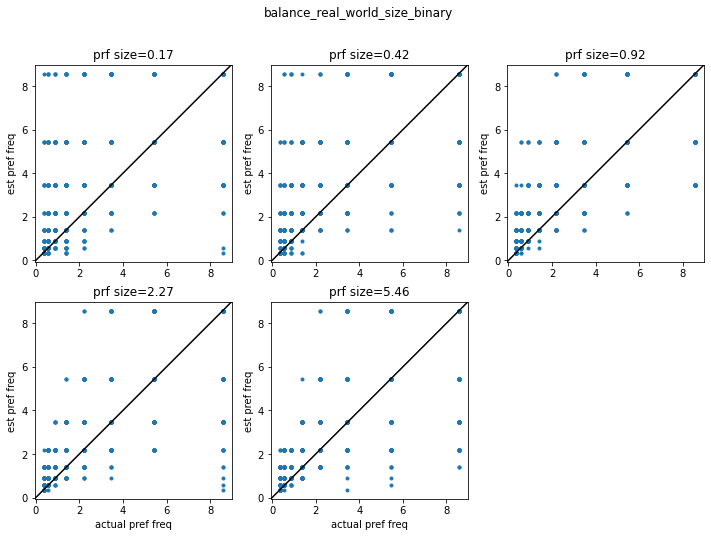

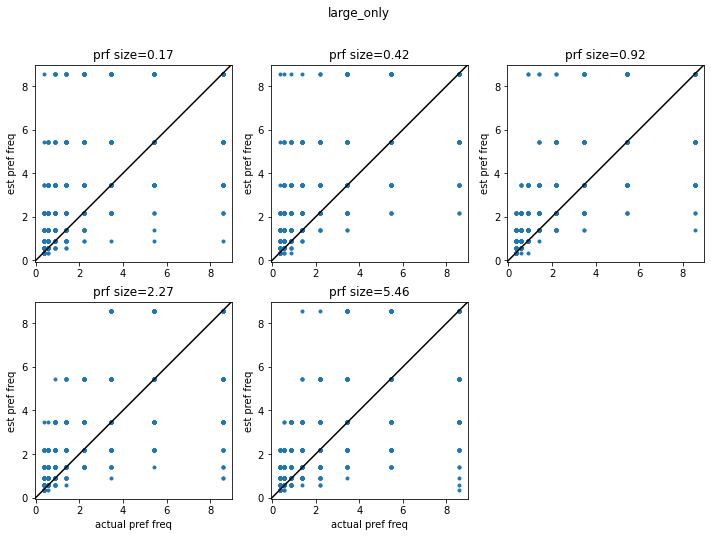

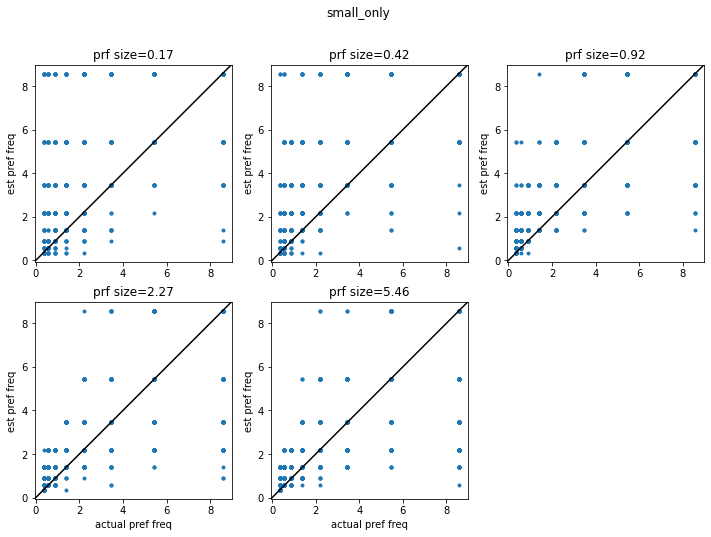

In [223]:
for fi, trial_subset in enumerate(trial_subsets):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

    plt.figure(figsize=(12,8))
    pi=0;
    est_sf = np.array(sf_unique)[preferred_sf_corr.astype(int)]
    for size in np.unique(prf_pars[:,2]):

        vox_inds = prf_pars[:,2]==size

        pi+=1
        plt.subplot(2,3,pi)
        plt.plot( sim_sf[vox_inds], est_sf[vox_inds], '.',alpha=1.0)
        # plt.xticks(sf_unique);
        # plt.yticks(sf_unique);
        plt.axis('square')
        lims = [-1,10]
        plt.plot(lims, lims, color='k')
        plt.title('prf size=%.2f'%(size*8.4))
        if pi>3:
            plt.xlabel('actual pref freq')
        plt.ylabel('est pref freq')
    
    plt.suptitle('%s'%trial_subset)

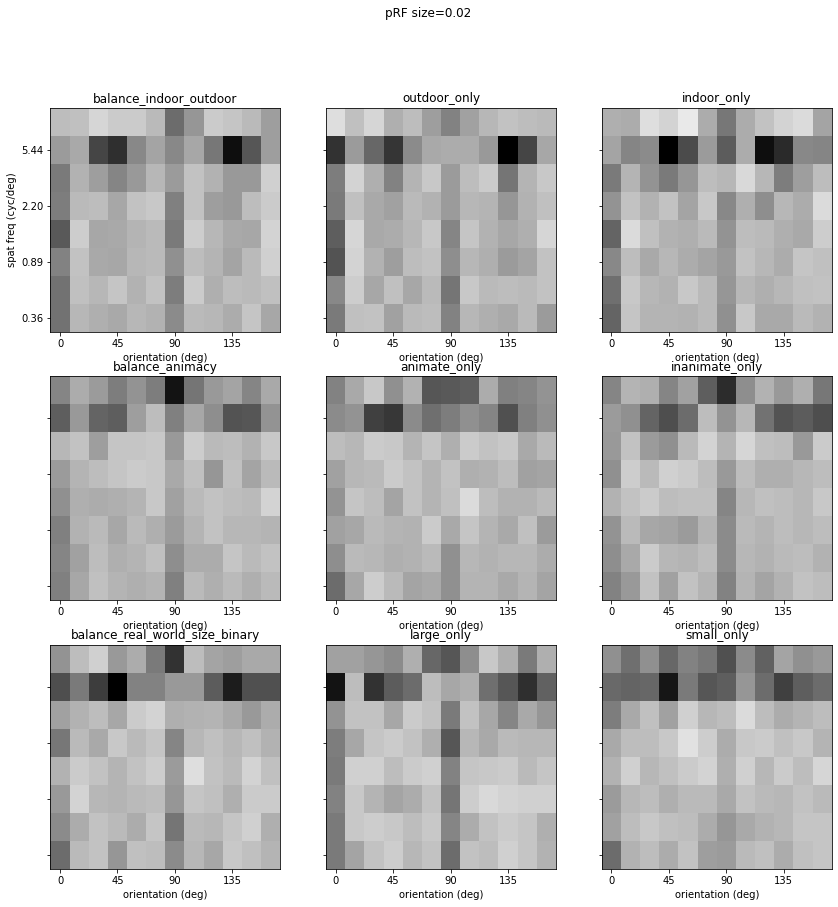

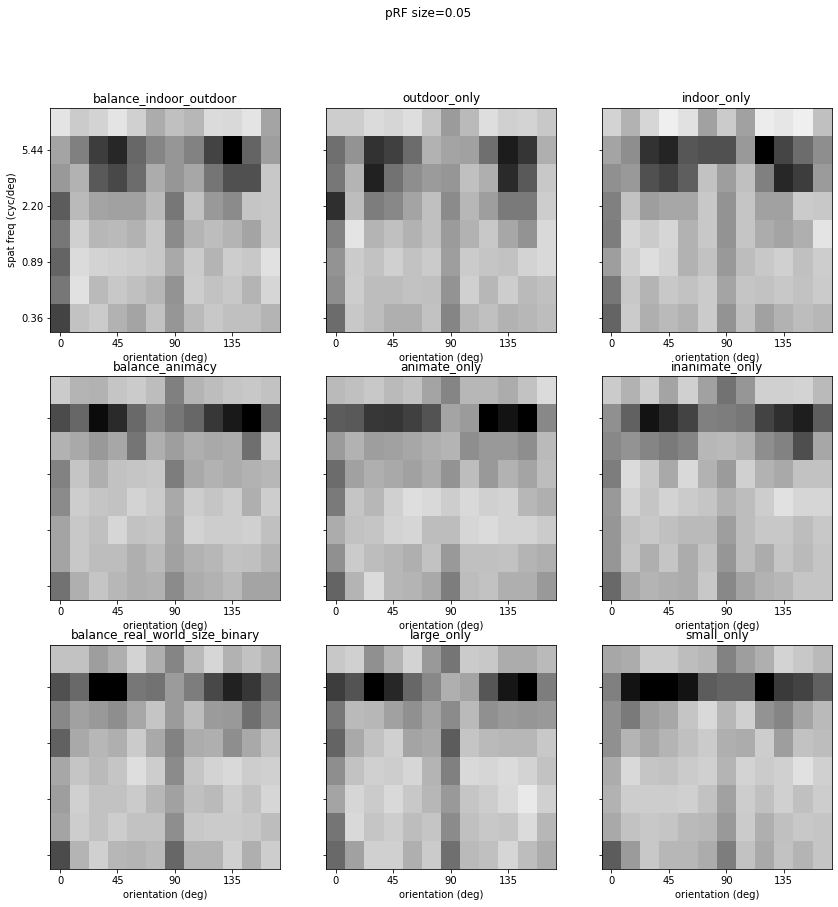

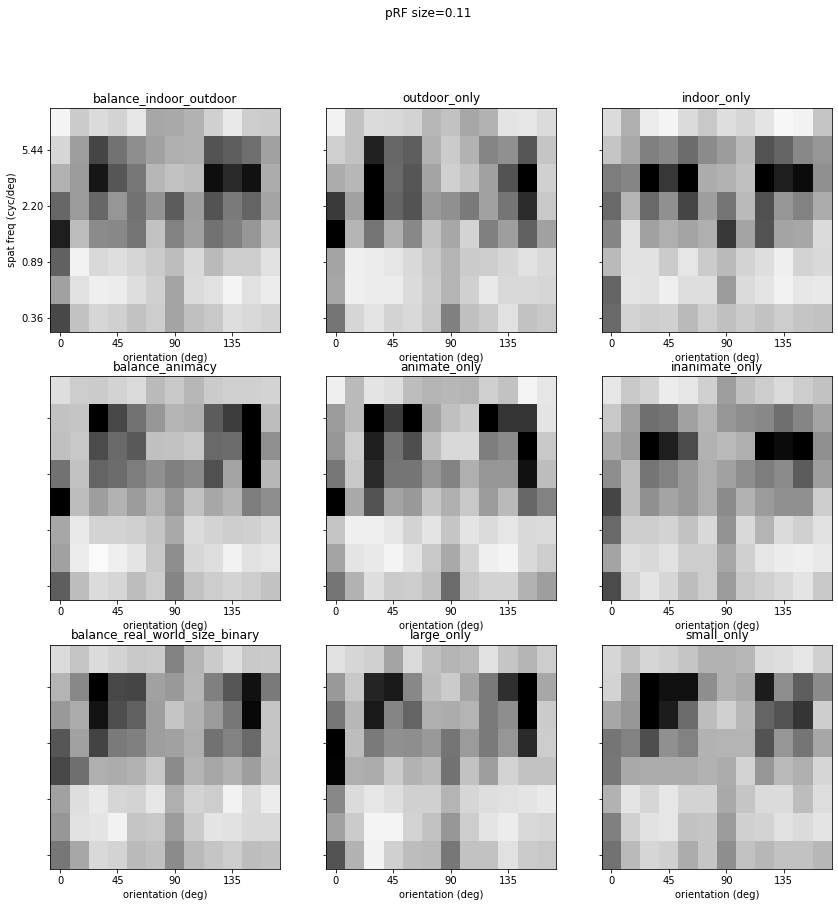

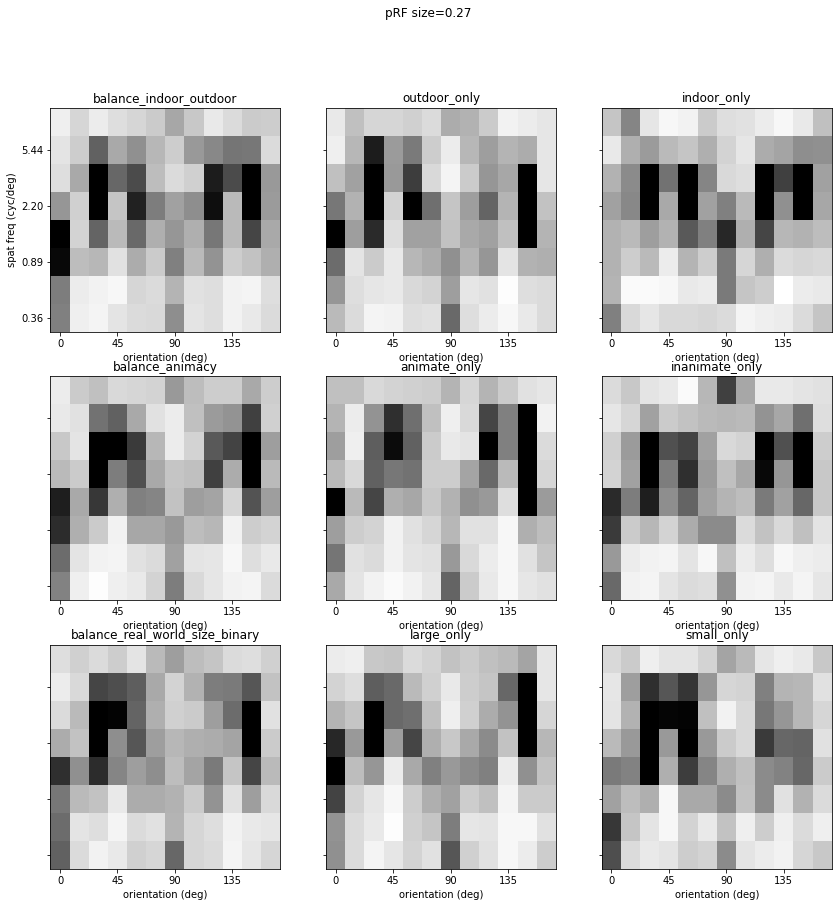

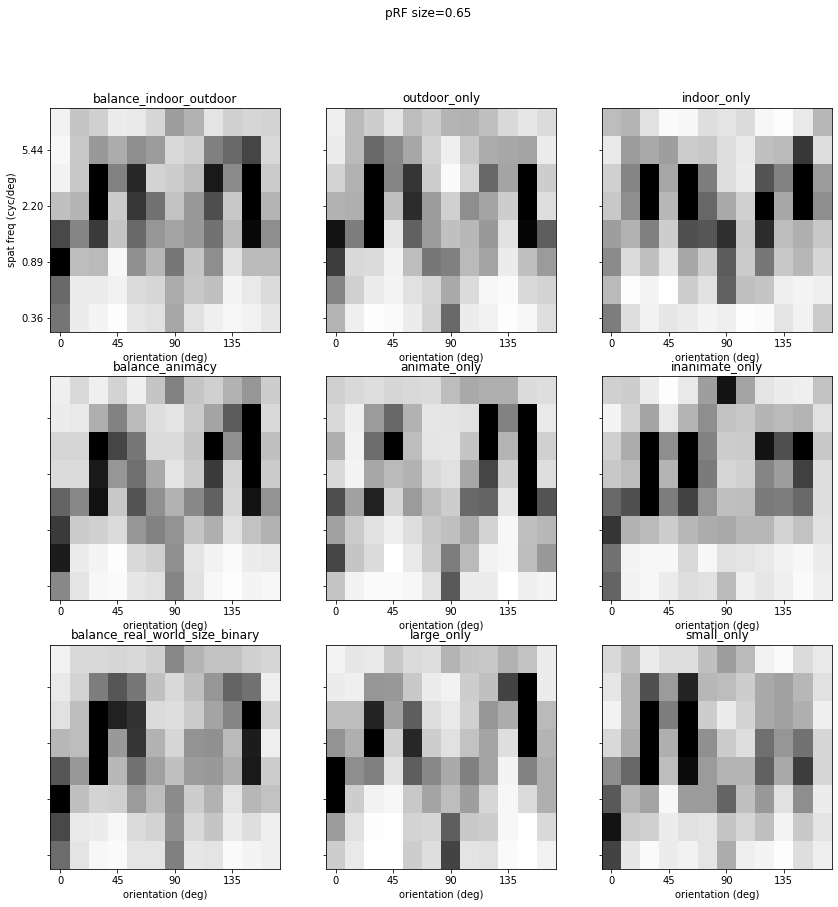

In [225]:
for size in np.unique(prf_pars[:,2]):

    vox_inds = prf_pars[:,2]==size

    plt.figure(figsize=(14,14))

    for fi, trial_subset in enumerate(trial_subsets):

        feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
        n_voxels = feature_corr.shape[0]
        allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
        mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
        mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

        # find maxes for orient/SF
        preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
        is_constant = np.all(mean_orient_corr[:,0:1]==mean_orient_corr, axis=1)
        assert not np.any(is_constant)
        preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

        n_vox = preferred_ori_corr.shape[0]
        feature_prefs_2dhist = np.zeros((n_vox, n_ori, n_sf))
        for vv in range(n_vox):
            oo = int(preferred_ori_corr[vv])
            ff = int(preferred_sf_corr[vv])
            feature_prefs_2dhist[vv,oo,ff] = 1


        plt.subplot(3,3,fi+1)
        vals = np.mean(feature_prefs_2dhist[vox_inds,:,:], axis=0).T
        plt.pcolormesh(vals, cmap='gray_r', vmin=0, vmax=0.03)
        # plt.colorbar()
        plt.xlabel('orientation (deg)')
        plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
        sf_ticks = sf_unique[[0,2,4,6]].round(2)
        if fi==0:
            plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
            plt.ylabel('spat freq (cyc/deg)')
        else:
            plt.yticks(np.array([0,2,4,6])+0.5, [])
        plt.title('%s'%trial_subset)

    plt.suptitle('pRF size=%.2f'%(size))

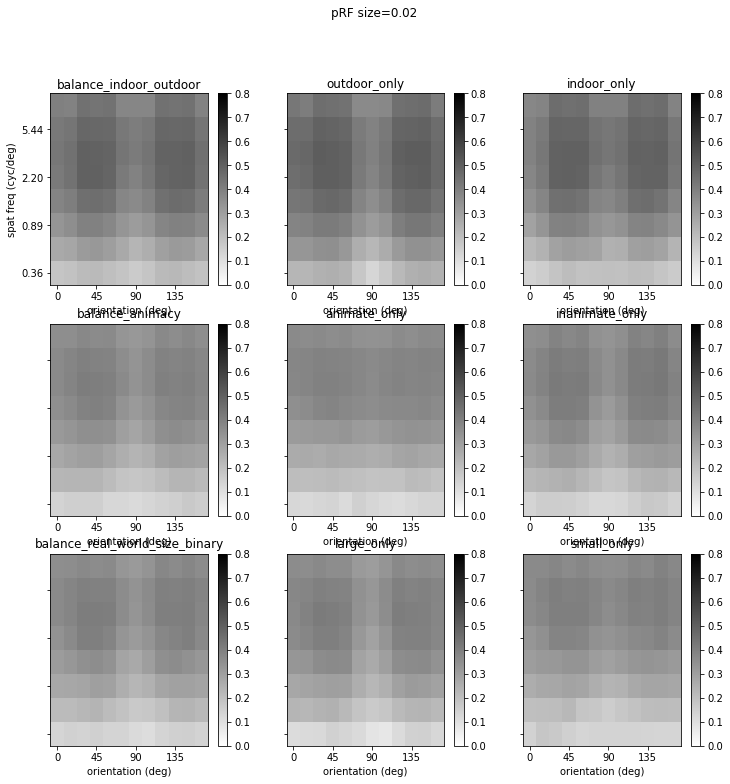

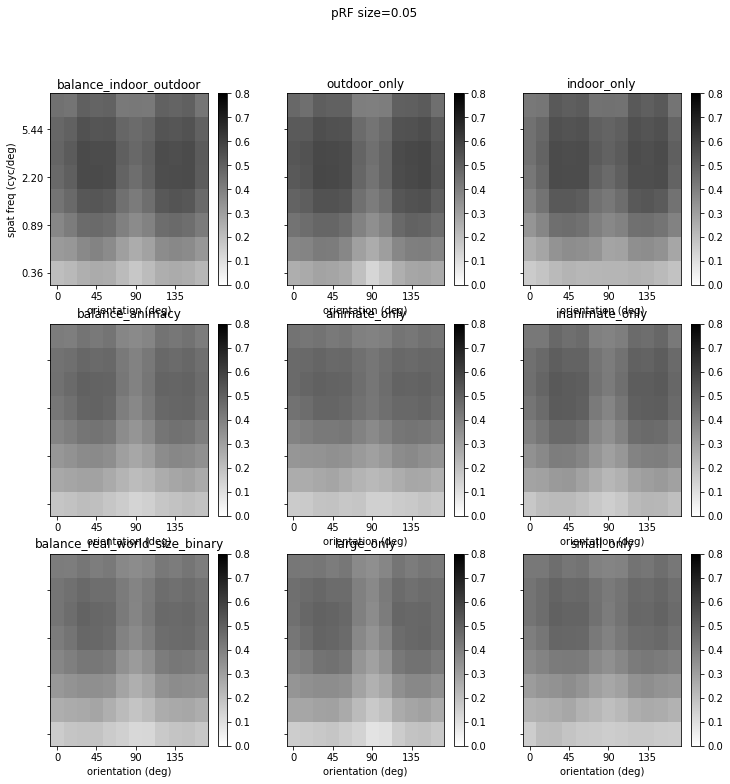

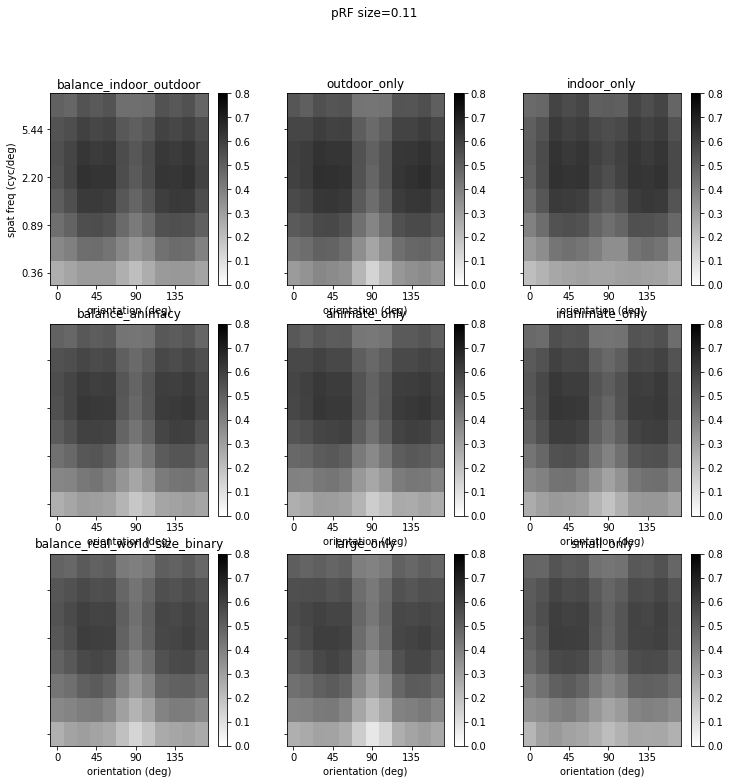

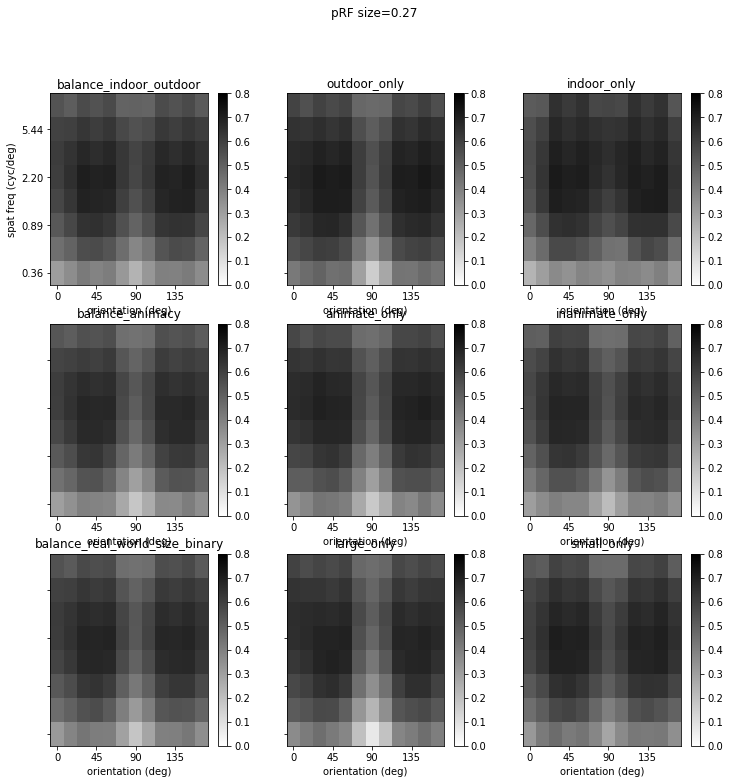

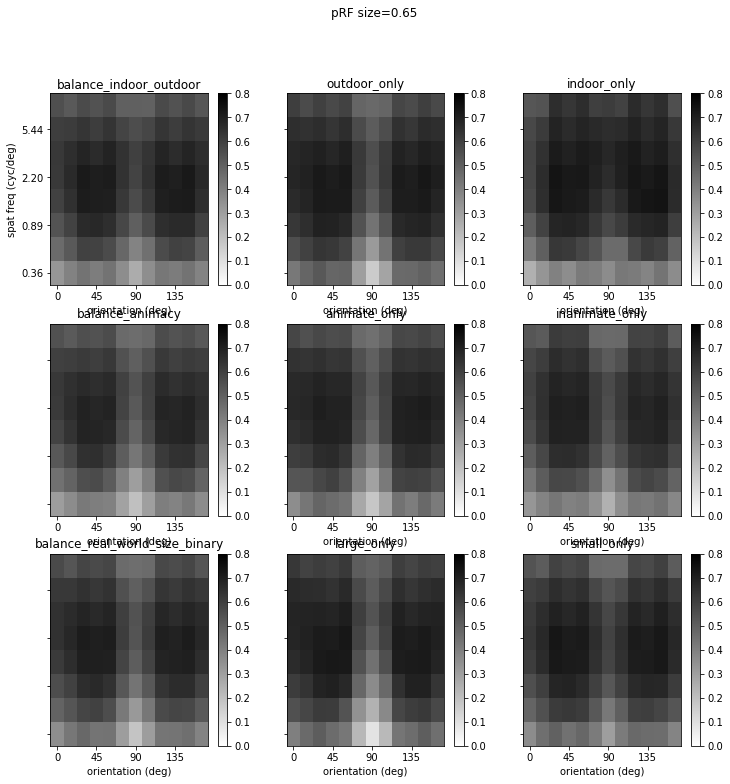

In [215]:
for size in np.unique(prf_pars[:,2]):

    vox_inds = prf_pars[:,2]==size

    plt.figure(figsize=(12,12))

    for fi, trial_subset in enumerate(trial_subsets):

        feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
        n_voxels = feature_corr.shape[0]
        allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
        
        plt.subplot(3,3,fi+1)
        # vals = 1-np.mean(allcorr_reshaped[vox_inds,:,:], axis=0).T
        # plt.pcolormesh(vals, cmap='gray_r',vmin=0, vmax=1)
        vals = np.mean(allcorr_reshaped[vox_inds,:,:], axis=0).T
        plt.pcolormesh(vals, cmap='gray_r',vmin=0, vmax=0.80)
        plt.colorbar()
        plt.xlabel('orientation (deg)')
        plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
        sf_ticks = sf_unique[[0,2,4,6]].round(2)
        if fi==0:
            plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
            plt.ylabel('spat freq (cyc/deg)')
        else:
            plt.yticks(np.array([0,2,4,6])+0.5, [])
        plt.title('%s'%trial_subset)

    plt.suptitle('pRF size=%.2f'%(size))

In [247]:
hist_2d_all = np.zeros((n_ori,n_sf, len(trial_subsets)))
                       
for fi, trial_subset in enumerate(trial_subsets):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    is_constant = np.all(mean_orient_corr[:,0:1]==mean_orient_corr, axis=1)
    assert not np.any(is_constant)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

    n_vox = preferred_ori_corr.shape[0]
    feature_prefs_2dhist = np.zeros((n_vox, n_ori, n_sf))
    for vv in range(n_vox):
        oo = int(preferred_ori_corr[vv])
        ff = int(preferred_sf_corr[vv])
        feature_prefs_2dhist[vv,oo,ff] = 1

    hist_2d_all[:,:,fi] = np.sum(feature_prefs_2dhist, axis=0)

#### None of them are zero

In [248]:
np.any(hist_2d_all==0)

False

In [249]:
np.unravel_index(np.argmin(hist_2d_all), np.shape(hist_2d_all))

(3, 7, 2)

In [250]:
oo,ff,fi = 3,7,2;
hist_2d_all[3,7,2]

31.0

In [251]:
feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(mean_orient_corr[:,0:1]==mean_orient_corr, axis=1)
assert not np.any(is_constant)
preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

n_vox = preferred_ori_corr.shape[0]
feature_prefs_2dhist = np.zeros((n_vox, n_ori, n_sf))
for vv in range(n_vox):
    oo = int(preferred_ori_corr[vv])
    ff = int(preferred_sf_corr[vv])
    feature_prefs_2dhist[vv,oo,ff] = 1

vinds = np.where(feature_prefs_2dhist[:,oo,ff]==1)[0]
len(vinds)

103

In [218]:
fi = 0;

feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(mean_orient_corr[:,0:1]==mean_orient_corr, axis=1)
assert not np.any(is_constant)
preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

n_vox = preferred_ori_corr.shape[0]
feature_prefs_2dhist = np.zeros((n_vox, n_ori, n_sf))
for vv in range(n_vox):
    oo = int(preferred_ori_corr[vv])
    ff = int(preferred_sf_corr[vv])
    feature_prefs_2dhist[vv,oo,ff] = 1

Text(0, 0.5, 'spat freq (cyc/deg)')

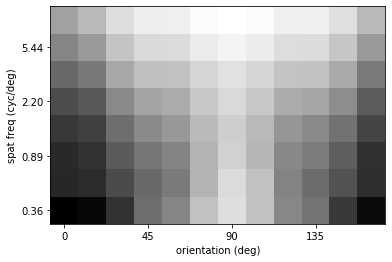

In [219]:
vox_inds = prf_pars[:,2]==size
vox_inds = vox_inds & (feature_prefs_2dhist[:,0,0]==1)

vals = np.mean(allcorr_reshaped[vox_inds,:,:], axis=0).T
plt.pcolormesh(vals, cmap='gray_r')
plt.xlabel('orientation (deg)')
plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
plt.ylabel('spat freq (cyc/deg)')


Text(0, 0.5, 'spat freq (cyc/deg)')

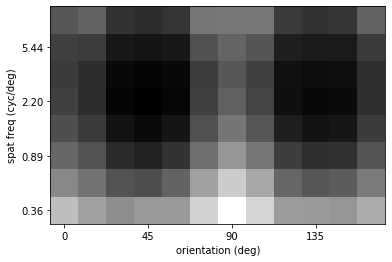

In [190]:
vox_inds = prf_pars[:,2]==size
vox_inds = vox_inds & (feature_prefs_2dhist[:,3,4]==1)

vals = np.mean(allcorr_reshaped[vox_inds,:,:], axis=0).T
plt.pcolormesh(vals, cmap='gray_r')
plt.xlabel('orientation (deg)')
plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
plt.ylabel('spat freq (cyc/deg)')


In [175]:
sim_orient[vox_inds]

array([  0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15.,
       165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,
        15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,
         0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15.,
       165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,
        15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,
         0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15.,
       165.,   0.,  15., 165.,   0.,  15., 165.,   0.,  15., 165.,   0.,
        15., 165.,   0.,  15., 165.,   0.,  15., 165.])

In [177]:
sim_sf[vox_inds]

array([0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714286,
       0.35714286, 0.35714286, 0.35714286, 0.35714286, 0.35714

#### Organize the feature sensitivity matrices
feature sensitivity = corr coef between model resp and feature channel activation

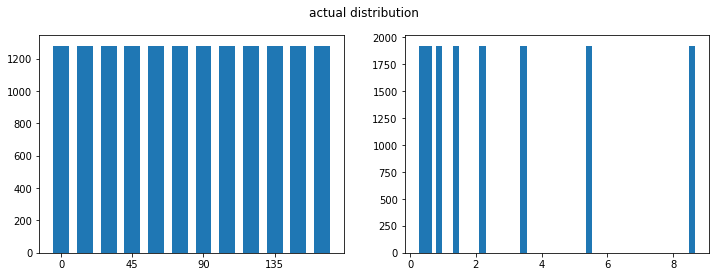

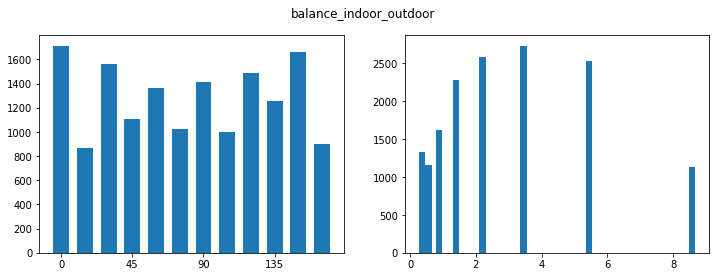

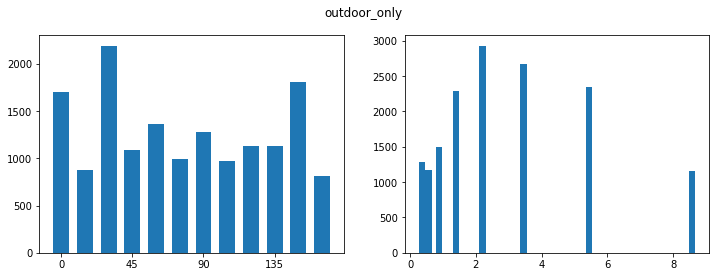

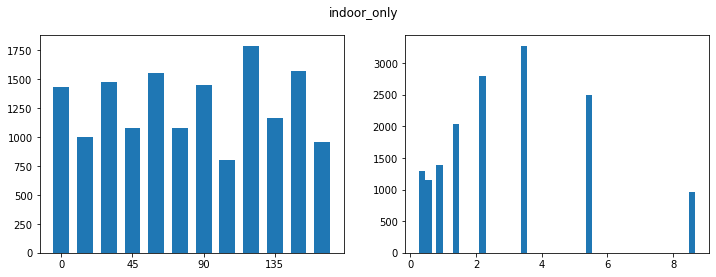

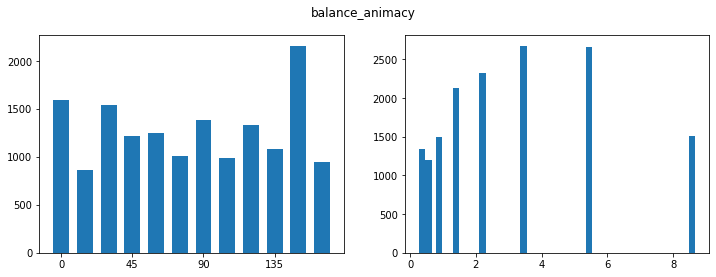

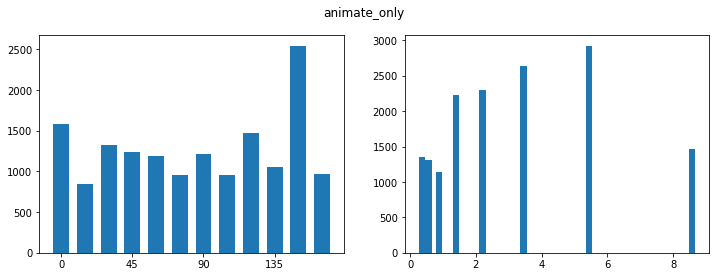

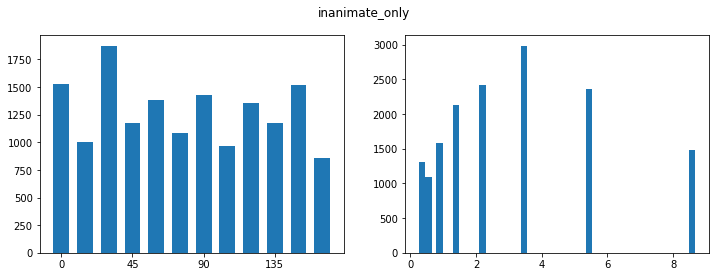

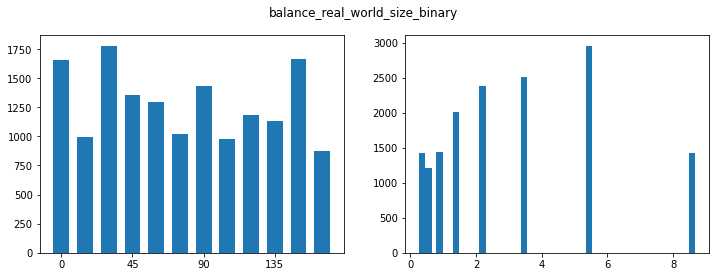

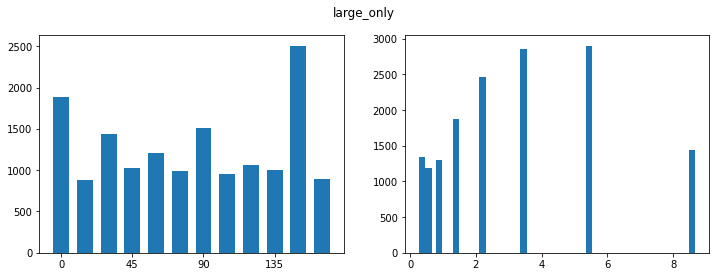

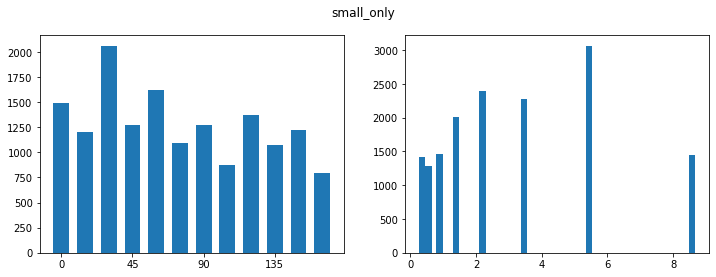

In [220]:
plt.figure(figsize=(12,4))
    
plt.subplot(1,2,1)
un, counts = np.unique(sim_orient, return_counts=True)
plt.bar(ori_unique, counts, width=10)
plt.xticks(np.arange(0,180,45))

plt.subplot(1,2,2)
un, counts = np.unique(sim_sf, return_counts=True)
plt.bar(sf_unique, counts, width=0.2)
plt.suptitle('actual distribution')

for fi, trial_subset in enumerate(trial_subsets):

    feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
    n_voxels = feature_corr.shape[0]
    allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
    mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
    mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

    # find maxes for orient/SF
    preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
    is_constant = np.all(mean_orient_corr[:,0:1]==mean_orient_corr, axis=1)
    assert not np.any(is_constant)
    preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    un, counts = np.unique(preferred_ori_corr, return_counts=True)
    plt.bar(ori_unique, counts, width=10)
    plt.xticks(np.arange(0,180,45))
    
    plt.subplot(1,2,2)
    un, counts = np.unique(preferred_sf_corr, return_counts=True)
    plt.bar(sf_unique, counts, width=0.2)
    plt.suptitle('%s'%trial_subset)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


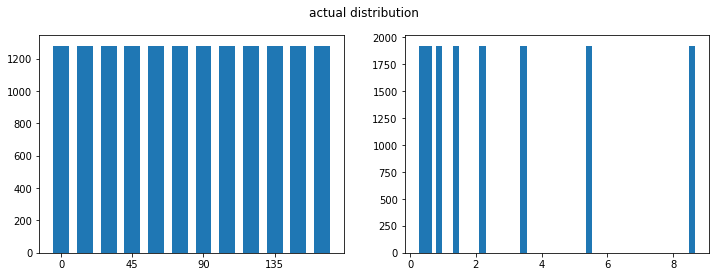

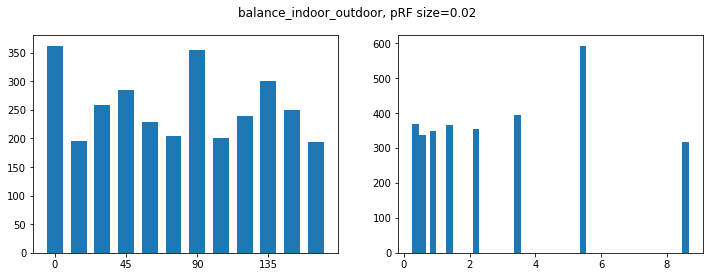

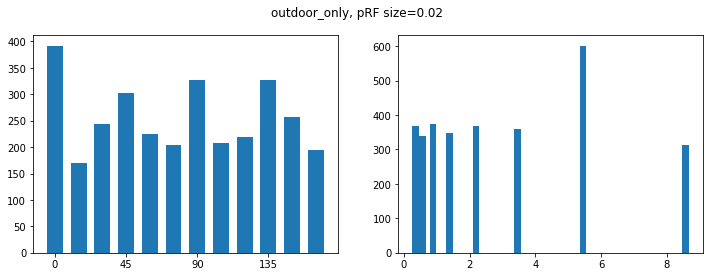

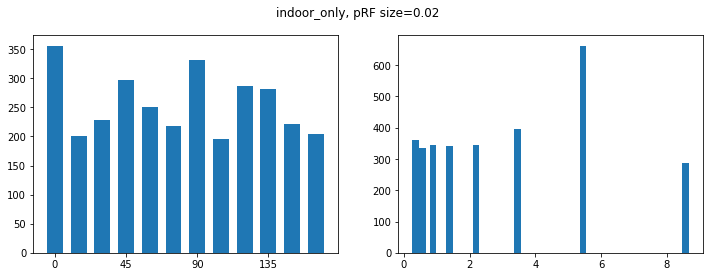

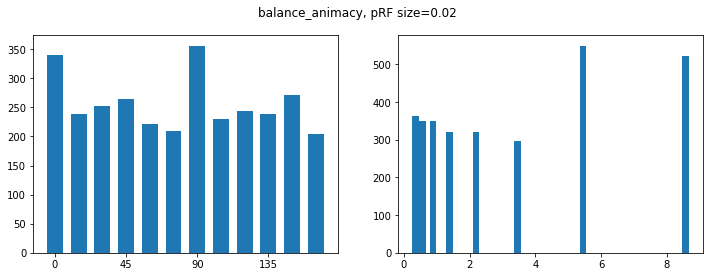

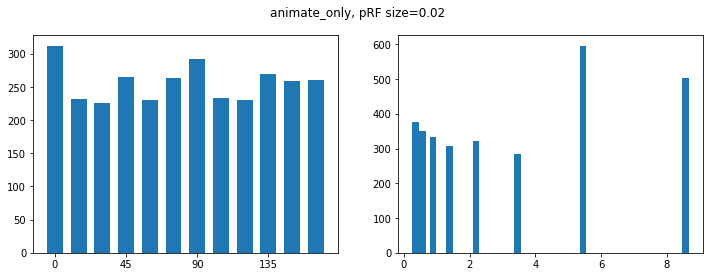

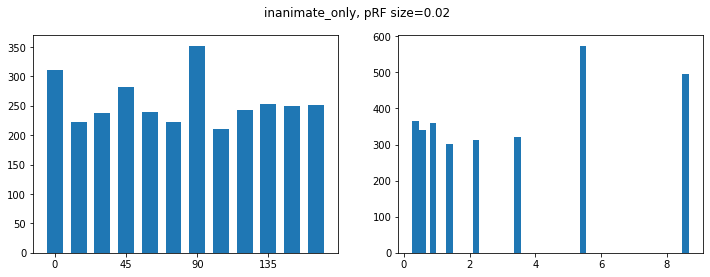

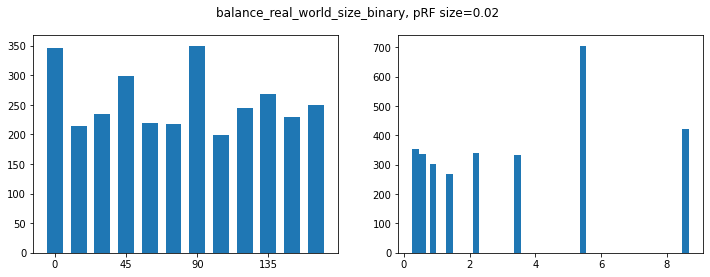

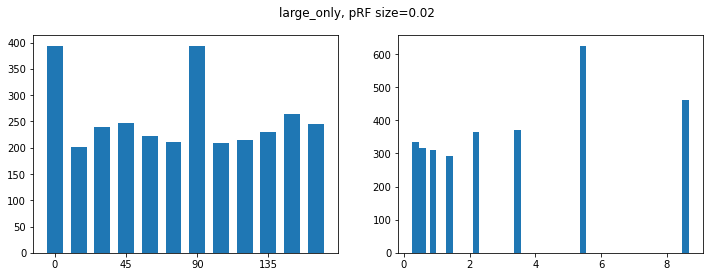

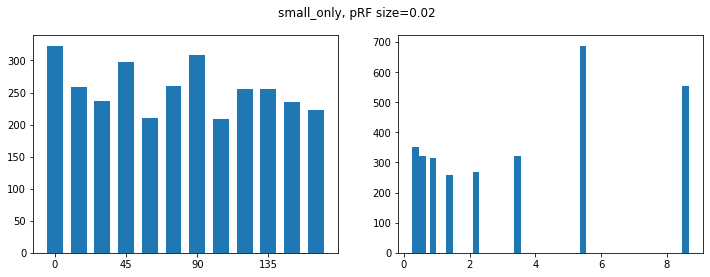

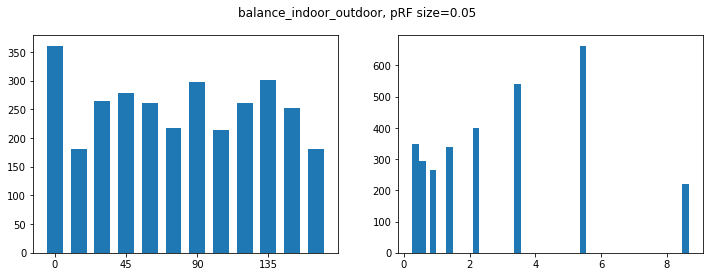

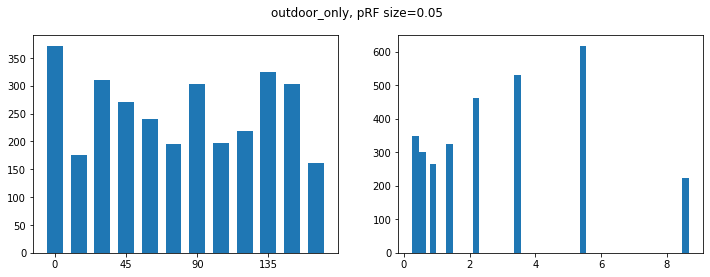

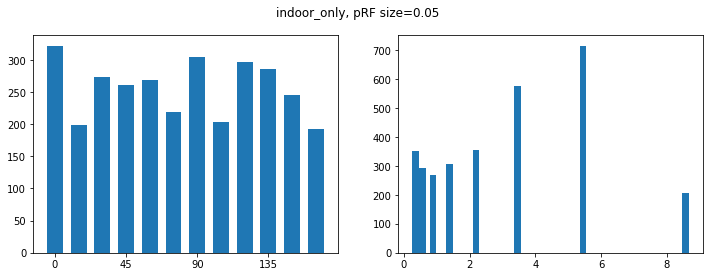

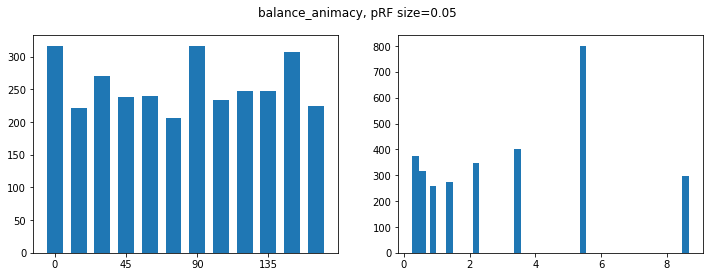

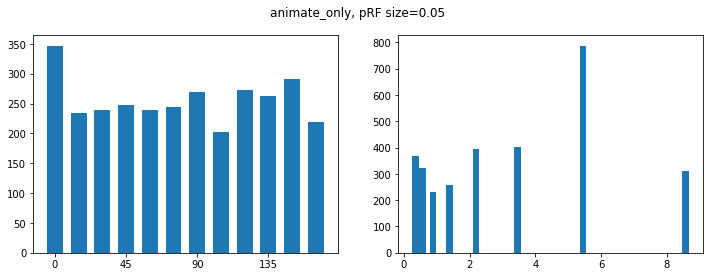

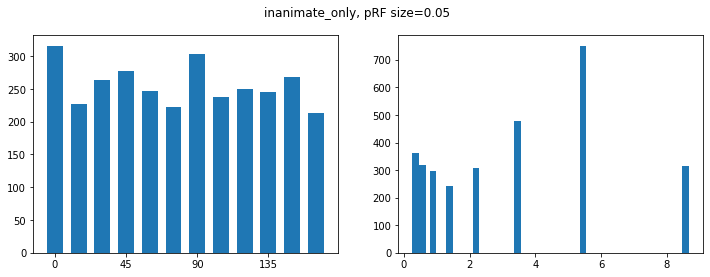

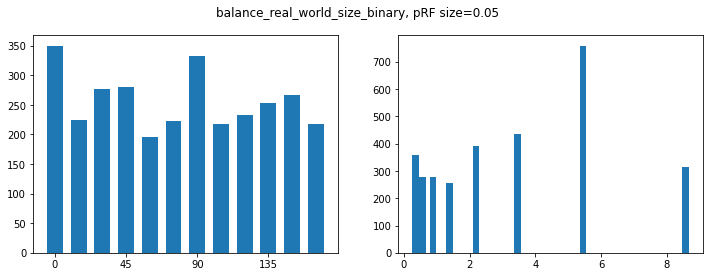

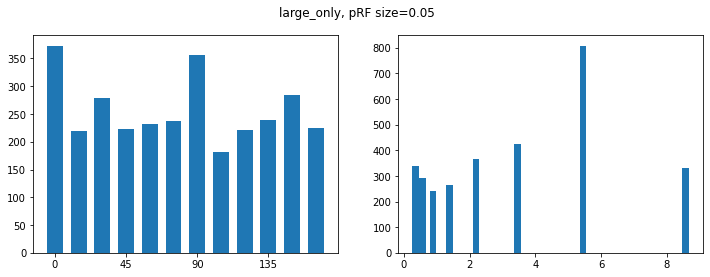

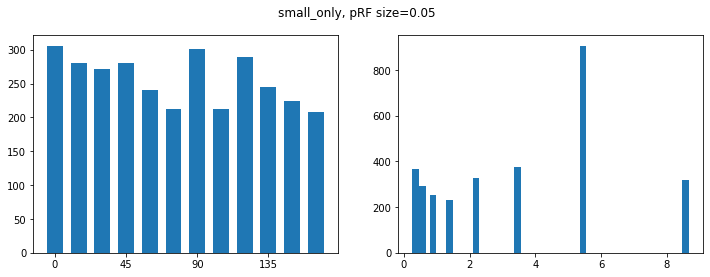

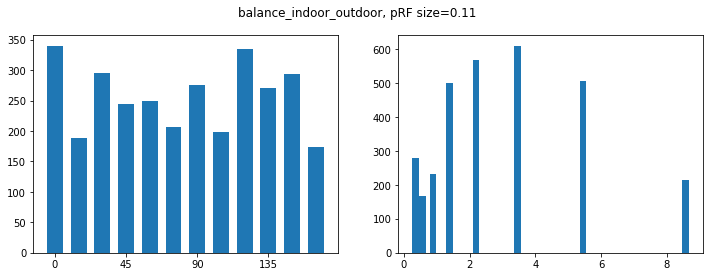

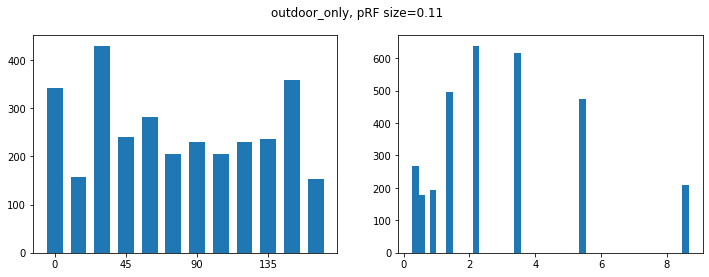

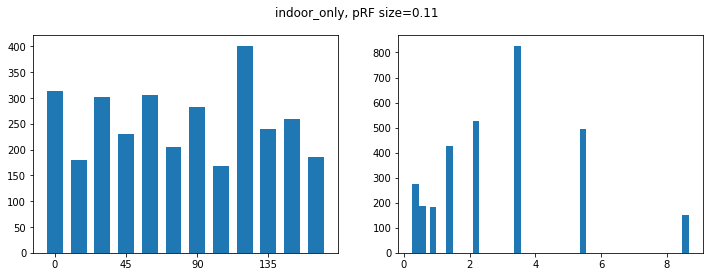

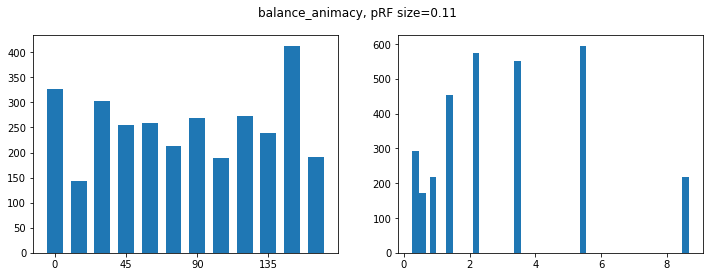

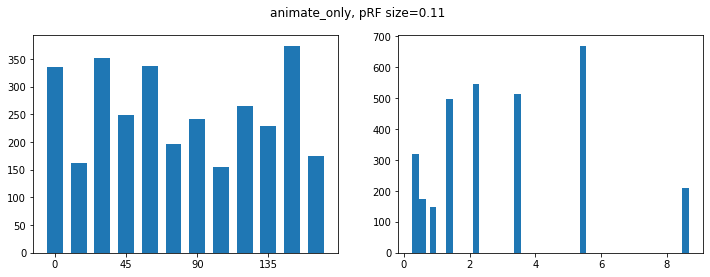

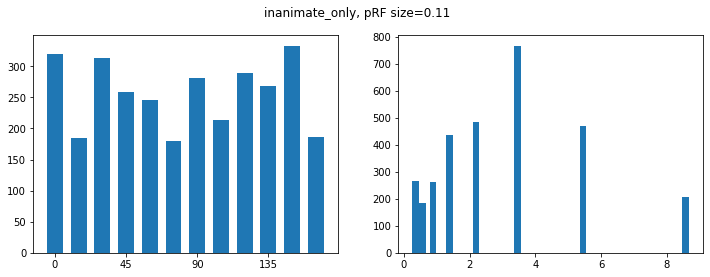

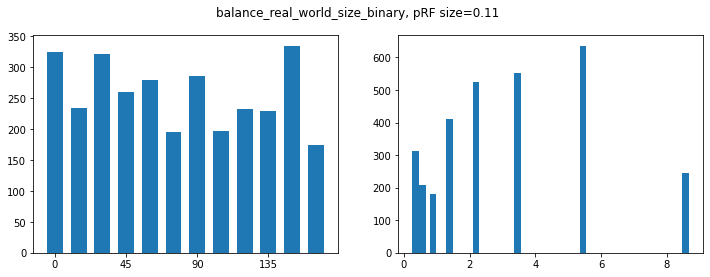

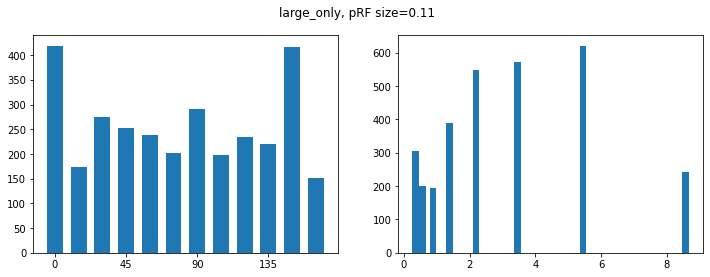

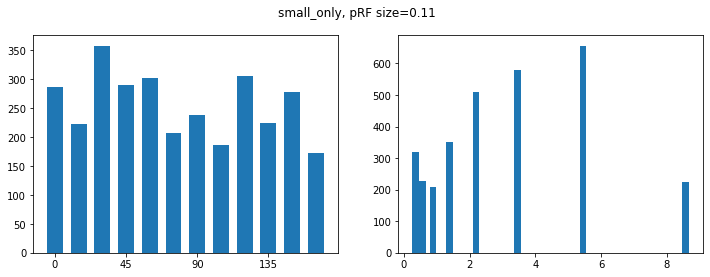

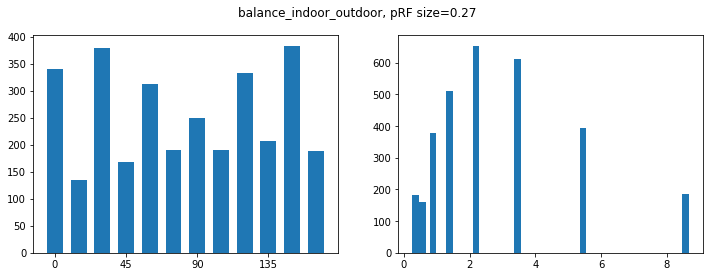

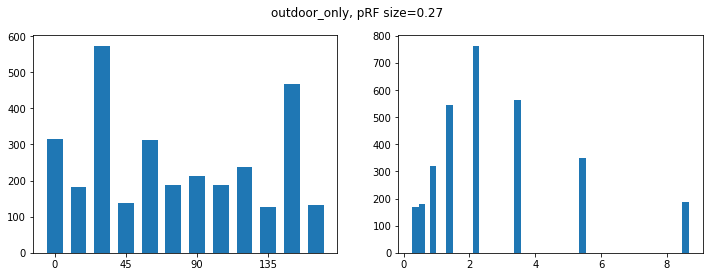

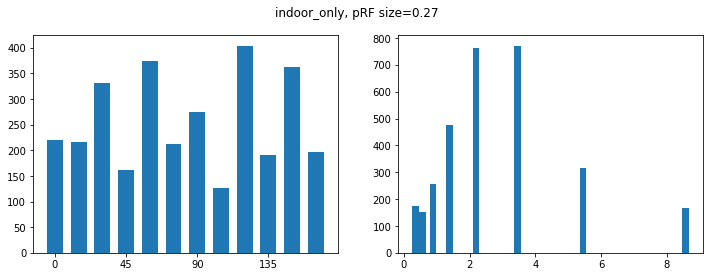

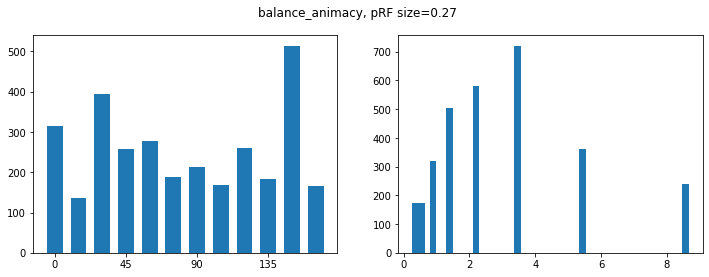

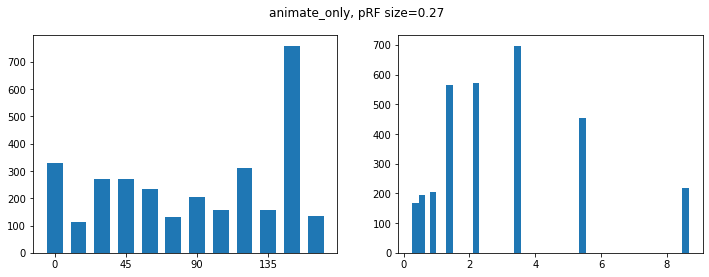

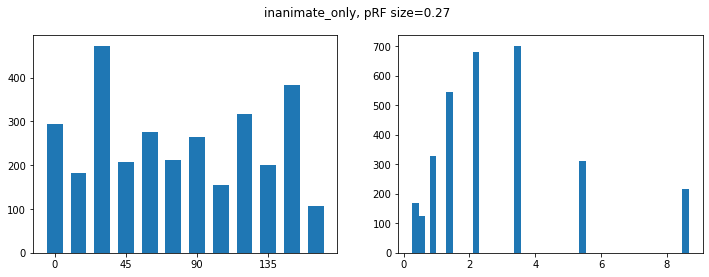

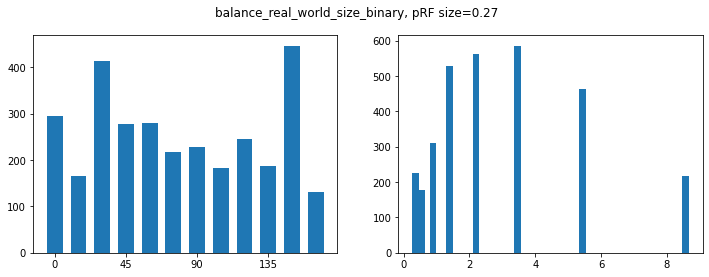

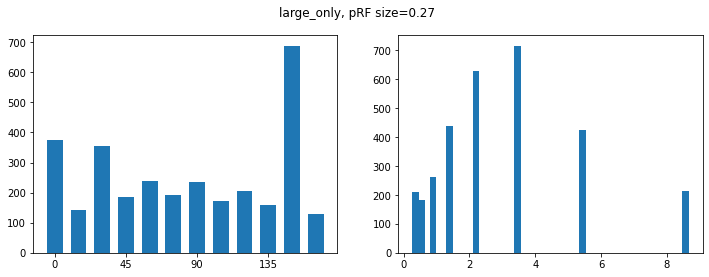

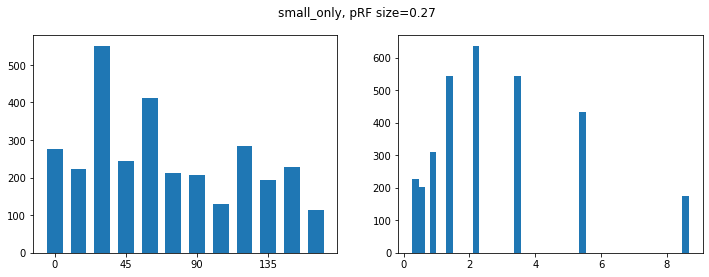

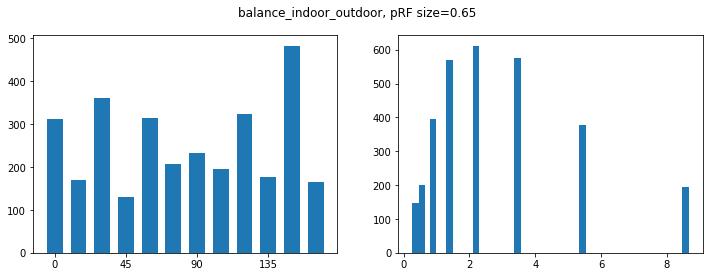

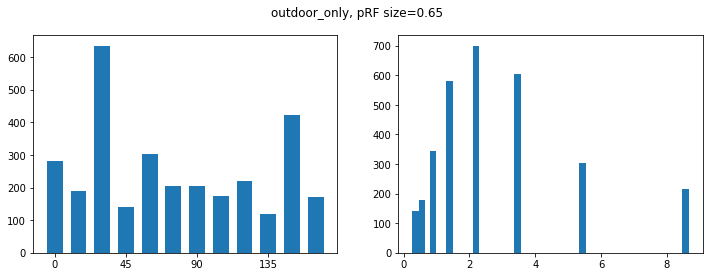

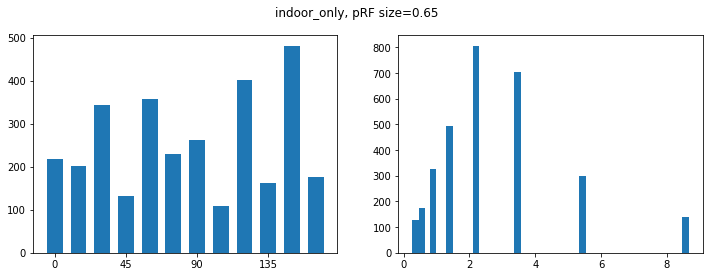

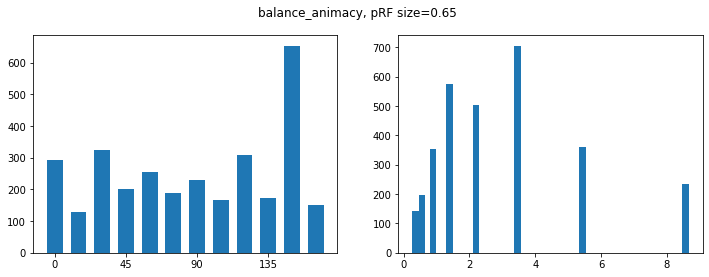

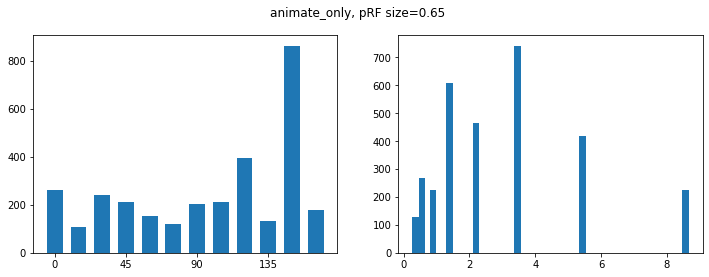

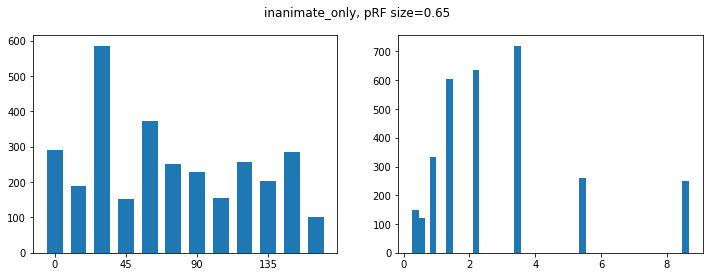

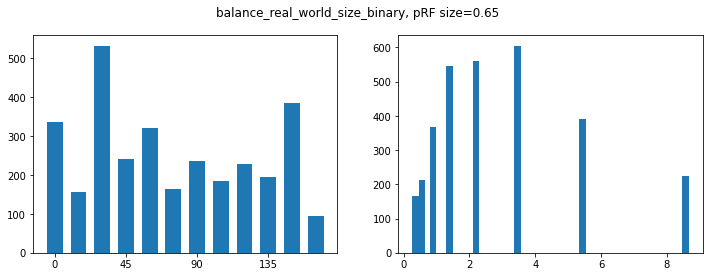

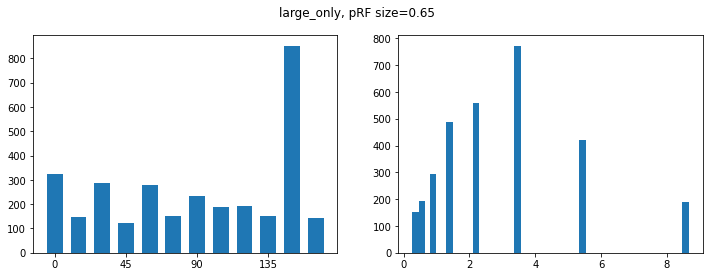

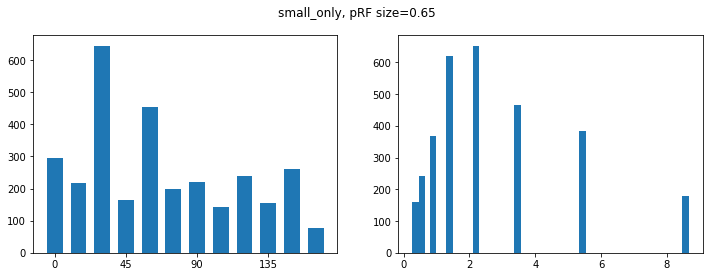

In [221]:
plt.figure(figsize=(12,4))
    
plt.subplot(1,2,1)
un, counts = np.unique(sim_orient, return_counts=True)
plt.bar(ori_unique, counts, width=10)
plt.xticks(np.arange(0,180,45))

plt.subplot(1,2,2)
un, counts = np.unique(sim_sf, return_counts=True)
plt.bar(sf_unique, counts, width=0.2)
plt.suptitle('actual distribution')

for size in np.unique(prf_pars[:,2]):

    vox_inds = prf_pars[:,2]==size

    for fi, trial_subset in enumerate(trial_subsets):

        feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
        n_voxels = feature_corr.shape[0]
        allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
        mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
        mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

        # find maxes for orient/SF
        preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
        is_constant = np.all(mean_orient_corr[:,0:1]==mean_orient_corr, axis=1)
        assert not np.any(is_constant)
        preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

        plt.figure(figsize=(12,4))

        plt.subplot(1,2,1)
        un, counts = np.unique(preferred_ori_corr[vox_inds], return_counts=True)
        plt.bar(ori_unique, counts, width=10)
        plt.xticks(np.arange(0,180,45))

        plt.subplot(1,2,2)
        un, counts = np.unique(preferred_sf_corr[vox_inds], return_counts=True)
        plt.bar(sf_unique, counts, width=0.2)
        plt.suptitle('%s, pRF size=%.2f'%(trial_subset, size))

In [130]:
np.unique(prf_pars[:,2])


array([0.02, 0.05, 0.11, 0.27, 0.65], dtype=float32)

In [137]:
sf_unique

array([0.35714286, 0.56236075, 0.88549892, 1.39431555, 2.19550336,
       3.45706178, 5.44352442, 8.57142857])

In [141]:
sf_unique*8.4

array([ 3.        ,  4.72383032,  7.43819096, 11.71225066, 18.44222825,
       29.03931899, 45.72560516, 72.        ])

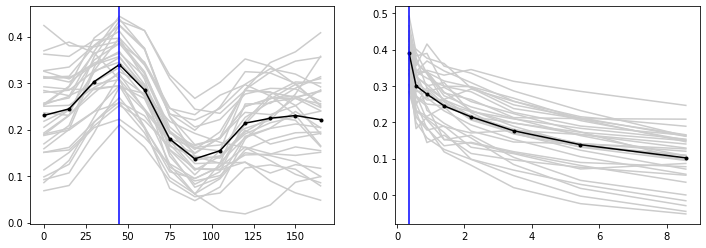

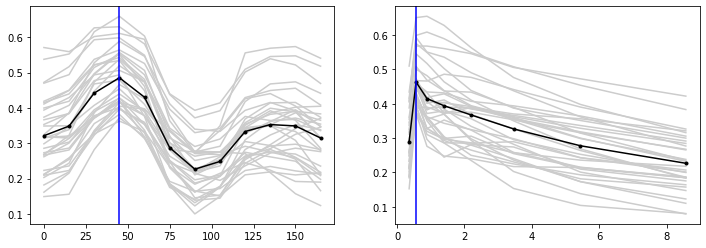

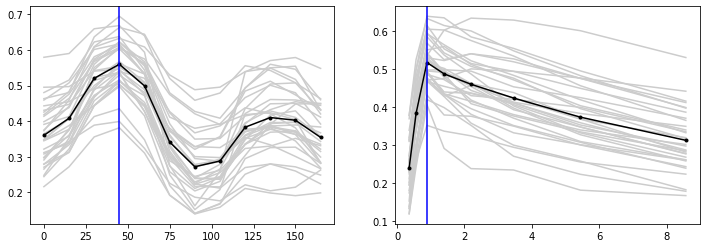

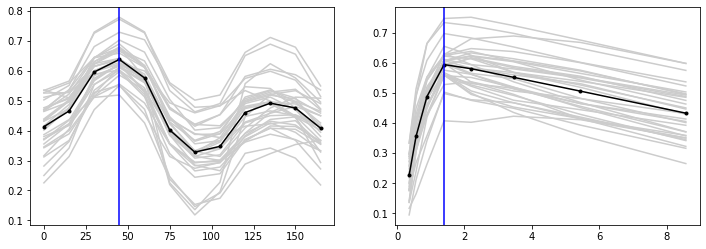

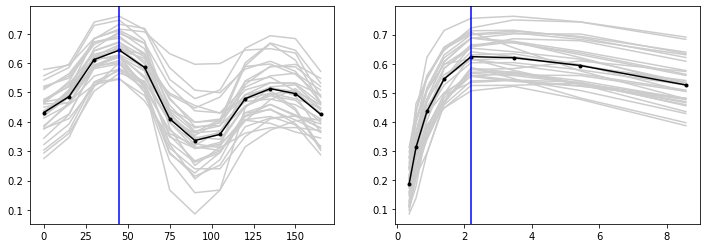

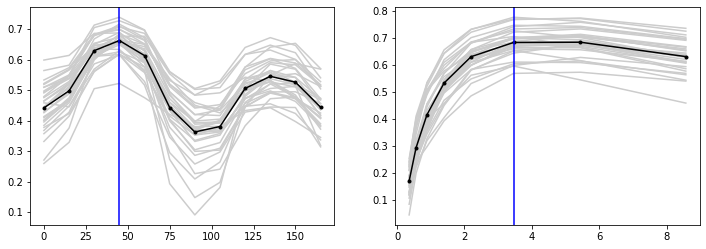

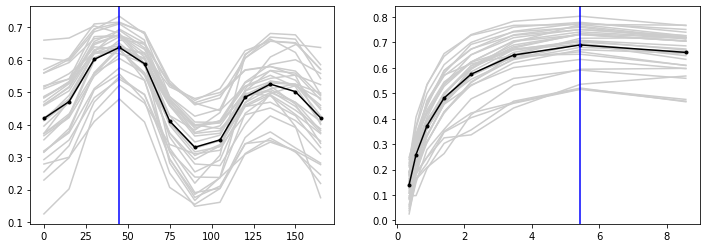

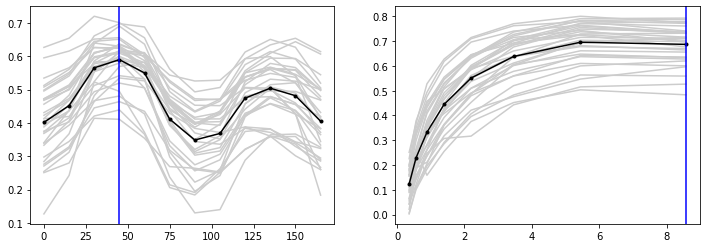

In [133]:
# fi = 0;
fi = 2;

size = np.unique(prf_pars[:,2])[0]

feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

ori = 45.0;
for sf in np.unique(sim_sf):

    vinds = (sim_orient==ori) & (sim_sf==sf)
    vinds = vinds & (prf_pars[:,2]==size)

    ori_tuning = mean_orient_corr[vinds,:]
    sf_tuning = mean_sf_corr[vinds,:]

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(ori_unique, ori_tuning.T, color=[0.8, 0.8, 0.8]);
    plt.plot(ori_unique, np.mean(ori_tuning, axis=0), '.-',color='k')
    plt.axvline(ori, color='b')

    plt.subplot(1,2,2)
    plt.plot(sf_unique, sf_tuning.T, color=[0.8, 0.8, 0.8]);
    plt.plot(sf_unique, np.mean(sf_tuning, axis=0), '.-',color='k')
    plt.axvline(sf, color='b')


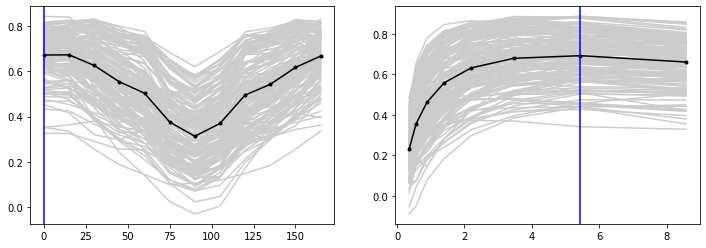

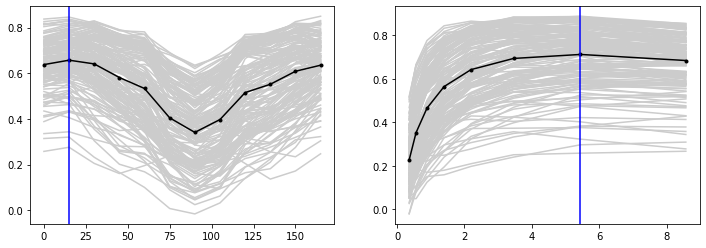

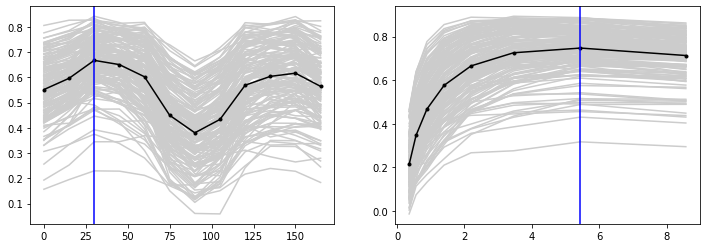

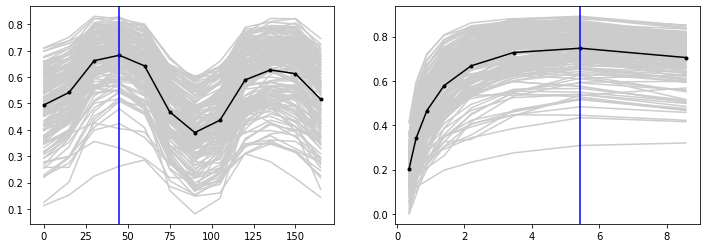

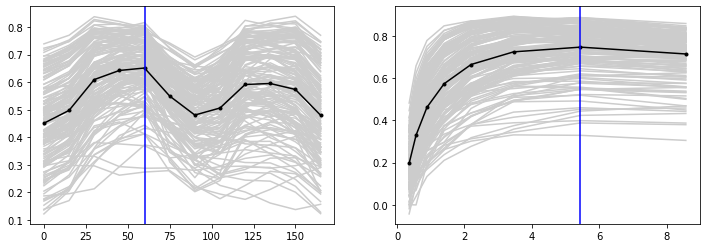

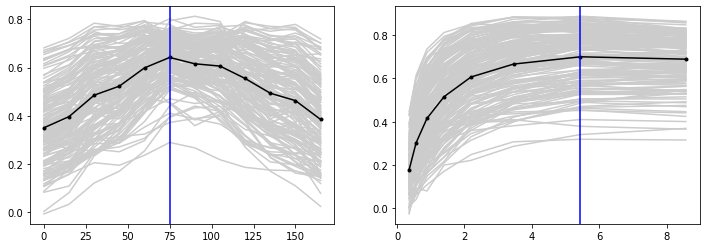

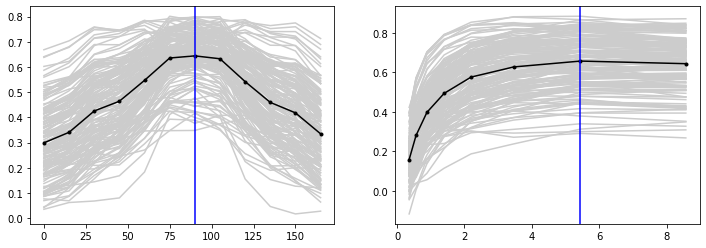

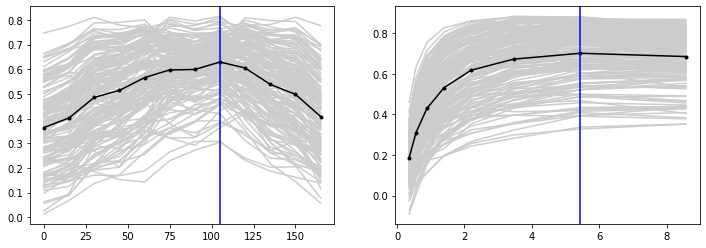

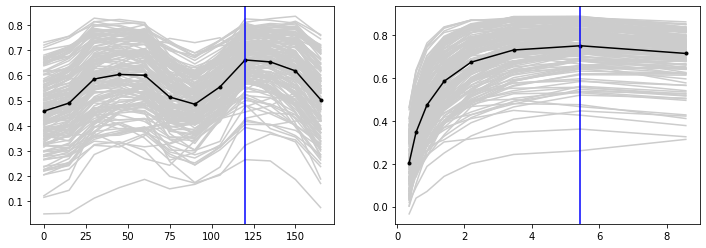

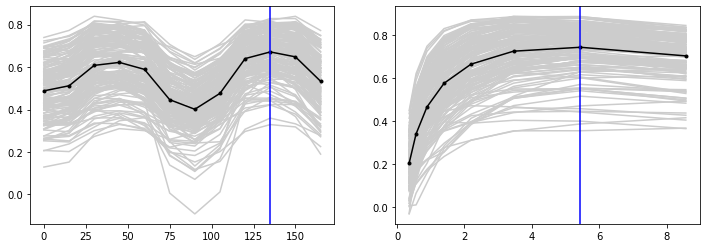

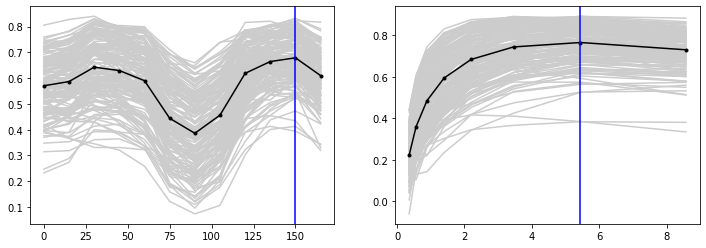

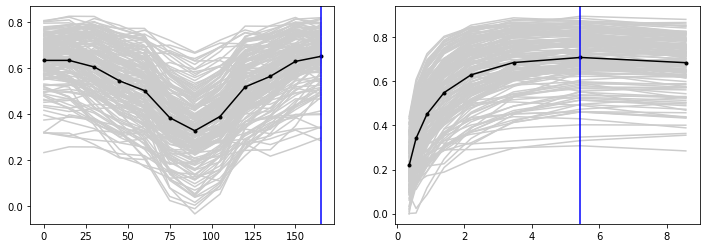

In [108]:
fi = 2;

feature_corr = np.concatenate([out[fi][si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)

sf = np.unique(sim_sf)[-2]
for ori in np.unique(ori_unique):

    vinds = (sim_orient==ori) & (sim_sf==sf)

    ori_tuning = mean_orient_corr[vinds,:]
    sf_tuning = mean_sf_corr[vinds,:]

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(ori_unique, ori_tuning.T, color=[0.8, 0.8, 0.8]);
    plt.plot(ori_unique, np.mean(ori_tuning, axis=0), '.-',color='k')
    plt.axvline(ori, color='b')

    plt.subplot(1,2,2)
    plt.plot(sf_unique, sf_tuning.T, color=[0.8, 0.8, 0.8]);
    plt.plot(sf_unique, np.mean(sf_tuning, axis=0), '.-',color='k')
    plt.axvline(sf, color='b')


In [18]:
preferred_ori_corr.shape

(15360,)